# SI 671 Final Project

## Data Import

In [2]:
# %pip install statsmodels
# %pip install pystan==2.19.1.1
# %pip install fbprophet

In [3]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult
from sklearn.metrics import r2_score
import seaborn as sns


In [4]:
from datetime import date, timedelta
first_day_of_weeks = []
def allsundays(year):
   d = date(year, 1, 1)                    # January 1st
   d += timedelta(days = 6 - d.weekday())  # First Sunday
   while d.year == year:
      yield d
      d += timedelta(days = 7)

for d in allsundays(2021):
   first_day_of_weeks.append(d)
first_day_of_weeks = first_day_of_weeks[:46]

#### Upload EU and NA csv, save as df

In [5]:
EU_df = pd.read_csv("EuropeanUnion.csv") 
NA_df = pd.read_csv("NorthAmerica.csv")

In [6]:
NA_df.shape

(136724, 67)

In [7]:
EU_df = EU_df[['YearWeekISO','ReportingCountry','FirstDose','SecondDose','DoseAdditional1','UnknownDose','TargetGroup','Vaccine','Population']].fillna(0)
EU_df['TotalDoses'] = EU_df['FirstDose'] + EU_df['SecondDose'] + EU_df['DoseAdditional1'] + EU_df['UnknownDose']
EU_df.head()

,YearWeekISO,ReportingCountry,FirstDose,SecondDose,DoseAdditional1,UnknownDose,TargetGroup,Vaccine,Population,TotalDoses
0,2020-W53,AT,0,0,0,0,ALL,MOD,8901064,0
1,2020-W53,AT,0,0,0,0,ALL,AZ,8901064,0
2,2020-W53,AT,5210,0,0,0,ALL,COM,8901064,5210
3,2020-W53,AT,0,0,0,0,ALL,UNK,8901064,0
4,2020-W53,AT,0,0,0,0,ALL,JANSS,8901064,0


In [8]:
NA_df = NA_df[(NA_df['location']=='United States') | (NA_df['location']=='Canada')].fillna(0)
NA_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
21667,CAN,North America,Canada,2020-01-26,1.0,1.0,0.0,0.0,0.0,0.0,...,12.0,16.6,0.0,2.5,82.43,0.929,-580.3,-2.28,-1.97,-15.243809
21668,CAN,North America,Canada,2020-01-27,1.0,0.0,0.0,0.0,0.0,0.0,...,12.0,16.6,0.0,2.5,82.43,0.929,0.0,0.00,0.00,0.000000
21669,CAN,North America,Canada,2020-01-28,2.0,1.0,0.0,0.0,0.0,0.0,...,12.0,16.6,0.0,2.5,82.43,0.929,0.0,0.00,0.00,0.000000
21670,CAN,North America,Canada,2020-01-29,2.0,0.0,0.0,0.0,0.0,0.0,...,12.0,16.6,0.0,2.5,82.43,0.929,0.0,0.00,0.00,0.000000
21671,CAN,North America,Canada,2020-01-30,2.0,0.0,0.0,0.0,0.0,0.0,...,12.0,16.6,0.0,2.5,82.43,0.929,0.0,0.00,0.00,0.000000


## Data Cleaning/Preprocessing
#### 2021-W01 to 2021-W46

#### Create df with each EU country as a column (rows = dates, cells = new vaccines)

In [9]:
EU_df = EU_df.rename(columns = {'YearWeekISO': "Year-Week", 'ReportingCountry':'Country'})
EU_all_ages = EU_df[EU_df['TargetGroup']=='ALL']
EU_all_ages = EU_all_ages.groupby(['Year-Week','Country']).sum()[['TotalDoses']].reset_index()
EU_all_ages.head()

,Year-Week,Country,TotalDoses
0,2020-W51,DK,4
1,2020-W52,BG,0
2,2020-W52,CY,369
3,2020-W52,CZ,1268
4,2020-W52,DE,24351


In [10]:
EU_country = EU_all_ages.pivot(index='Year-Week', columns='Country', values='TotalDoses').fillna(0)[3:-2]
EU_country['First_Day_of_Week'] = first_day_of_weeks
EU_country = EU_country.set_index('First_Day_of_Week')
EU_country.index = pd.to_datetime(EU_country.index)
EU_country.head()

Country,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
First_Day_of_Week,,,,,,,,,,,,,,,,,,,,,
2021-01-03,26114.0,27226.0,8734.0,3076.0,35764.0,376310.0,59719.0,8395.0,40879.0,323429.0,...,4732.0,3001.0,33758.0,21160.0,322264.0,98433.0,0.0,72890.0,18022.0,29879.0
2021-01-10,85173.0,99078.0,4980.0,4747.0,72649.0,541421.0,52086.0,7230.0,36552.0,508355.0,...,9024.0,6484.0,43201.0,29126.0,546172.0,102953.0,0.0,159644.0,19071.0,33236.0
2021-01-17,97660.0,122484.0,7690.0,7258.0,86526.0,678148.0,36460.0,7824.0,80655.0,341185.0,...,3158.0,7872.0,89350.0,30682.0,487258.0,311029.0,0.0,233116.0,15225.0,37732.0
2021-01-24,48875.0,91753.0,14982.0,7281.0,71707.0,644363.0,60919.0,12657.0,111359.0,375780.0,...,4761.0,7636.0,184981.0,49337.0,946696.0,176517.0,692984.0,182420.0,18004.0,47005.0
2021-01-31,97740.0,139184.0,15913.0,7768.0,82224.0,845771.0,59423.0,14921.0,125874.0,519281.0,...,8521.0,12914.0,219923.0,97970.0,992292.0,123983.0,164311.0,200502.0,19796.0,68333.0


#### Create df with each EU manufacturer as a column (rows = dates, cells = new vaccines)

In [11]:
EU_all_ages_manu = EU_df[EU_df['TargetGroup']=='ALL']
EU_all_ages_manu = EU_all_ages_manu.groupby(['Year-Week','Vaccine']).sum()[['TotalDoses']].reset_index()
EU_all_ages_manu.tail()

,Year-Week,Vaccine,TotalDoses
330,2021-W48,AZ,123
331,2021-W48,COM,88341
332,2021-W48,JANSS,11019
333,2021-W48,MOD,6880
334,2021-W48,UNK,2


In [12]:
EU_manufacturer = EU_all_ages_manu.pivot(index='Year-Week', columns='Vaccine', values='TotalDoses').fillna(0)[3:-2]
EU_manufacturer['First_Day_of_Week'] = first_day_of_weeks
EU_manufacturer = EU_manufacturer.set_index('First_Day_of_Week')
EU_manufacturer.index = pd.to_datetime(EU_manufacturer.index)
EU_manufacturer.head(10)

Vaccine,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
First_Day_of_Week,,,,,,,
2021-01-03,315.0,0.0,2905228.0,31.0,412.0,0.0,102123.0
2021-01-10,414.0,0.0,4047672.0,4.0,46944.0,0.0,348208.0
2021-01-17,598.0,0.0,4048464.0,4.0,123700.0,0.0,680087.0
2021-01-24,500.0,0.0,5816998.0,6.0,78402.0,0.0,582170.0
2021-01-31,3355.0,0.0,5796228.0,21.0,206667.0,0.0,576472.0
2021-02-07,388463.0,0.0,5407415.0,2.0,334377.0,2385.0,769743.0
2021-02-14,1336788.0,0.0,5258386.0,8.0,501345.0,16099.0,816654.0
2021-02-21,2489420.0,162077.0,5659287.0,13.0,440474.0,837.0,847008.0
2021-02-28,3510171.0,206515.0,6433866.0,113.0,796432.0,3435.0,1311148.0


#### Create df with each EU age-group as a column (rows = dates, cells = new vaccines)

In [13]:
EU_age_groups_first = EU_df[EU_df['TargetGroup']!='ALL']
EU_age_groups_first = EU_age_groups_first.groupby(['Year-Week','TargetGroup']).sum()[['TotalDoses']].reset_index()
EU_age_groups_first.tail()

,Year-Week,TargetGroup,TotalDoses
798,2021-W48,Age70_79,12699
799,2021-W48,Age80+,4819
800,2021-W48,Age<18,4700
801,2021-W48,AgeUNK,1168
802,2021-W48,HCW,462


In [14]:
### WHICH GROUPS DO WE WANT TO LOOK AT?
### IF ONLY AGE, GET RID OF THE FOLLOWING COLUMNS: 1_Age60+, 1_Age<60, Age<18, HCW, LTCF, AgeUnk, ALL
EU_age_groups = EU_age_groups_first.pivot(index='Year-Week', columns='TargetGroup', values='TotalDoses').fillna(0)[3:-2]
EU_age_groups['First_Day_of_Week'] = first_day_of_weeks
EU_age_groups = EU_age_groups.set_index('First_Day_of_Week')
EU_age_groups.index = pd.to_datetime(EU_age_groups.index)
EU_age_groups = EU_age_groups.drop(columns = ['1_Age60+', '1_Age<60', 'Age<18', 'HCW', 'LTCF', 'AgeUNK'])
EU_age_groups = EU_age_groups[['Age0_4', 'Age5_9', 'Age10_14','Age15_17', 'Age18_24', 'Age25_49', 'Age50_59', 'Age60_69', 'Age70_79', 'Age80+']]
EU_age_groups.head(10)

TargetGroup,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
First_Day_of_Week,,,,,,,,,,
2021-01-03,1.0,1.0,4.0,305.0,53013.0,757868.0,501399.0,296997.0,97442.0,247845.0
2021-01-10,5.0,6.0,16.0,628.0,113502.0,1103826.0,782113.0,451600.0,207087.0,498295.0
2021-01-17,3.0,4.0,9.0,730.0,82375.0,891709.0,596737.0,386770.0,517047.0,1078999.0
2021-01-24,3.0,0.0,10.0,652.0,97287.0,1089687.0,693915.0,450994.0,536074.0,1321473.0
2021-01-31,7.0,8.0,18.0,693.0,131995.0,1216287.0,803776.0,505942.0,580974.0,1313649.0
2021-02-07,3.0,6.0,17.0,748.0,123404.0,1188066.0,740626.0,488727.0,754548.0,1530951.0
2021-02-14,5.0,8.0,24.0,537.0,137839.0,1246652.0,732711.0,522483.0,909496.0,2116566.0
2021-02-21,14.0,13.0,35.0,701.0,132408.0,1312365.0,863517.0,735495.0,1175872.0,2511854.0
2021-02-28,7.0,21.0,47.0,640.0,147238.0,1561019.0,1132340.0,1165882.0,1773989.0,2762780.0


#### Create df with EU and North America as columns -  non aggregated (rows = dates, cells = new vaccines)


In [15]:
NA_df['date']= pd.to_datetime(NA_df['date'])
NA_df['Year-Week'] = NA_df['date'].dt.strftime('%Y-W%U')
NA_df_updated = NA_df[NA_df['date'] > '2020-12-16']
NA_df_updated.tail()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,Year-Week
129703,USA,North America,United States,2021-11-25,48125425.0,32602.0,84531.857,776090.0,366.0,966.286,...,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0,2021-W47
129704,USA,North America,United States,2021-11-26,48176523.0,51098.0,73890.429,776349.0,259.0,752.143,...,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0,2021-W47
129705,USA,North America,United States,2021-11-27,48201079.0,24556.0,71470.857,776536.0,187.0,731.286,...,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0,2021-W47
129706,USA,North America,United States,2021-11-28,48229210.0,28131.0,70093.714,776639.0,103.0,729.857,...,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0,2021-W48
129707,USA,North America,United States,2021-11-29,48438302.0,209092.0,78465.714,778601.0,1962.0,834.143,...,24.6,0.0,2.77,78.86,0.926,0.0,0.0,0.0,0.0,2021-W48


In [16]:
NA_weekly = NA_df_updated.groupby(['Year-Week', 'location']).sum()[['new_vaccinations']].reset_index()
NA_weekly.tail()

,Year-Week,location,new_vaccinations
99,2021-W46,United States,9629272.0
100,2021-W47,Canada,422953.0
101,2021-W47,United States,5692131.0
102,2021-W48,Canada,214339.0
103,2021-W48,United States,49107.0


In [17]:
#North America df to combine with EU
NA_countries = NA_weekly.pivot(index='Year-Week', columns='location', values='new_vaccinations').fillna(0)[4:-2]
NA_countries['First_Day_of_Week'] = first_day_of_weeks
NA_countries = NA_countries.set_index('First_Day_of_Week')
NA_countries.index = pd.to_datetime(NA_countries.index)
NA_countries.head()

location,Canada,United States
First_Day_of_Week,,
2021-01-03,189804.0,5522549.0
2021-01-10,249513.0,7108417.0
2021-01-17,262113.0,8331210.0
2021-01-24,153539.0,10222198.0
2021-01-31,114293.0,11631190.0


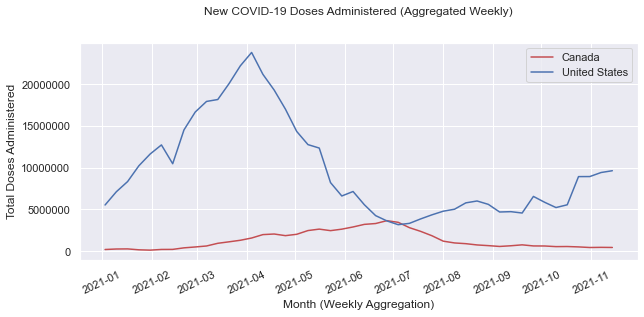

In [18]:
sns.set_theme(style="darkgrid", palette="deep")
plt.figure(figsize=(10,4))
sns.lineplot(x = "First_Day_of_Week", y = "Canada", data = NA_countries, color='r', markers='First_Day_of_Week')
sns.lineplot(x = "First_Day_of_Week", y = "United States", data = NA_countries)
plt.ylabel("Total Doses Administered")
plt.xlabel("Month (Weekly Aggregation)")
plt.title("New COVID-19 Doses Administered (Aggregated Weekly)", y=1.1)
plt.legend(['Canada','United States'],loc='upper right')
plt.xticks(rotation = 25)
plt.ticklabel_format(style='plain', axis='y')

In [19]:
#EU df to combine with North America
# EU_country_agg = EU_country_agg.reset_index()
EU_country.head()

Country,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
First_Day_of_Week,,,,,,,,,,,,,,,,,,,,,
2021-01-03,26114.0,27226.0,8734.0,3076.0,35764.0,376310.0,59719.0,8395.0,40879.0,323429.0,...,4732.0,3001.0,33758.0,21160.0,322264.0,98433.0,0.0,72890.0,18022.0,29879.0
2021-01-10,85173.0,99078.0,4980.0,4747.0,72649.0,541421.0,52086.0,7230.0,36552.0,508355.0,...,9024.0,6484.0,43201.0,29126.0,546172.0,102953.0,0.0,159644.0,19071.0,33236.0
2021-01-17,97660.0,122484.0,7690.0,7258.0,86526.0,678148.0,36460.0,7824.0,80655.0,341185.0,...,3158.0,7872.0,89350.0,30682.0,487258.0,311029.0,0.0,233116.0,15225.0,37732.0
2021-01-24,48875.0,91753.0,14982.0,7281.0,71707.0,644363.0,60919.0,12657.0,111359.0,375780.0,...,4761.0,7636.0,184981.0,49337.0,946696.0,176517.0,692984.0,182420.0,18004.0,47005.0
2021-01-31,97740.0,139184.0,15913.0,7768.0,82224.0,845771.0,59423.0,14921.0,125874.0,519281.0,...,8521.0,12914.0,219923.0,97970.0,992292.0,123983.0,164311.0,200502.0,19796.0,68333.0


In [20]:
#Combine EU and NA Dataframes to create a df that shows all countries daily incremental vaccine numbers
EU_NA_non_aggregated = NA_countries.join(EU_country, how='outer')
EU_NA_non_aggregated.head()

,Canada,United States,AT,BE,BG,CY,CZ,DE,DK,EE,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
First_Day_of_Week,,,,,,,,,,,,,,,,,,,,,
2021-01-03,189804.0,5522549.0,26114.0,27226.0,8734.0,3076.0,35764.0,376310.0,59719.0,8395.0,...,4732.0,3001.0,33758.0,21160.0,322264.0,98433.0,0.0,72890.0,18022.0,29879.0
2021-01-10,249513.0,7108417.0,85173.0,99078.0,4980.0,4747.0,72649.0,541421.0,52086.0,7230.0,...,9024.0,6484.0,43201.0,29126.0,546172.0,102953.0,0.0,159644.0,19071.0,33236.0
2021-01-17,262113.0,8331210.0,97660.0,122484.0,7690.0,7258.0,86526.0,678148.0,36460.0,7824.0,...,3158.0,7872.0,89350.0,30682.0,487258.0,311029.0,0.0,233116.0,15225.0,37732.0
2021-01-24,153539.0,10222198.0,48875.0,91753.0,14982.0,7281.0,71707.0,644363.0,60919.0,12657.0,...,4761.0,7636.0,184981.0,49337.0,946696.0,176517.0,692984.0,182420.0,18004.0,47005.0
2021-01-31,114293.0,11631190.0,97740.0,139184.0,15913.0,7768.0,82224.0,845771.0,59423.0,14921.0,...,8521.0,12914.0,219923.0,97970.0,992292.0,123983.0,164311.0,200502.0,19796.0,68333.0


#### Create df with EU and North America as columns -  non aggregated (rows = dates, cells = new vaccines)

In [21]:
EU_country['All EU'] = EU_country.sum(axis=1)
EU_aggregated = EU_country[['All EU']]
EU_aggregated.head()

Country,All EU
First_Day_of_Week,
2021-01-03,3008109.0
2021-01-10,4443242.0
2021-01-17,4852853.0
2021-01-24,6478076.0
2021-01-31,6582743.0


In [22]:
NA_countries['All NA'] = NA_countries.sum(axis=1)
NA_aggregated = NA_countries[['All NA']]
NA_aggregated.head()

location,All NA
First_Day_of_Week,
2021-01-03,5712353.0
2021-01-10,7357930.0
2021-01-17,8593323.0
2021-01-24,10375737.0
2021-01-31,11745483.0


In [23]:
#Combine EU and NA Dataframes to create a df that shows all EU v NA incremental vaccine numbers
EU_NA_aggregated = NA_aggregated.join(EU_aggregated, how='outer')
EU_NA_aggregated.tail()

,All NA,All EU
First_Day_of_Week,,
2021-10-17,6095496.0,7914985.0
2021-10-24,9425655.0,8515826.0
2021-10-31,9360575.0,8759840.0
2021-11-07,9862748.0,11818307.0
2021-11-14,10064449.0,14595338.0


In [24]:
EU_country = EU_country.drop(columns=['All EU'])
NA_countries = NA_countries.drop(columns=['All NA'])

## EU Time Series Decomposition

#### Find trend, cyclical component, seasonal and noise by:
- EU country (df = EU_country)
- Manufacturer (df = EU_manufacturer)
- Age-group (df = EU_age_groups)


In [25]:
def sea_decomp(input_df):
    from statsmodels.tsa.seasonal import seasonal_decompose
    empty_dict = {}
    
    for col in input_df.columns:
        empty_dict[col] = seasonal_decompose(input_df[col], period=4).seasonal
        
    output_df = pd.DataFrame(data=empty_dict, index=input_df.index)
    return output_df

In [26]:
EU_country_sea_decomp = sea_decomp(EU_country)
EU_country_sea_decomp.head()

,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
First_Day_of_Week,,,,,,,,,,,,,,,,,,,,,
2021-01-03,-9484.071591,-27803.709659,-5570.354261,-1317.247727,-3680.890909,-25719.771023,-6672.613920,-1300.184091,-17559.493750,-30545.859091,...,-2352.366193,-226.813352,-47186.566477,1116.777557,-37166.465909,-47701.244034,-37325.680966,-20829.057386,662.116193,-3896.621591
2021-01-10,20195.428409,7406.640341,-1697.116761,-142.247727,10901.009091,35451.853977,-12355.126420,1856.340909,18698.856250,90766.815909,...,3710.146307,-891.625852,2629.008523,22560.190057,-35566.815909,-18351.681534,4296.356534,26095.267614,3969.378693,1108.053409
2021-01-17,-359.490909,23104.352841,4662.752557,255.730682,-6621.519318,9142.413068,6558.103125,-966.504545,3000.858523,5147.152273,...,-394.662784,779.935511,42624.750568,-9904.023580,34086.311364,77664.423011,8187.179261,11589.588068,-3813.321307,2223.034091
2021-01-24,-10351.865909,-2707.283523,2604.718466,1203.764773,-598.598864,-18874.496023,12469.637216,410.347727,-4140.221023,-65368.109091,...,-963.117330,338.503693,1932.807386,-13772.944034,38646.970455,-11611.497443,24842.145170,-16855.798295,-818.173580,565.534091
2021-01-31,-9484.071591,-27803.709659,-5570.354261,-1317.247727,-3680.890909,-25719.771023,-6672.613920,-1300.184091,-17559.493750,-30545.859091,...,-2352.366193,-226.813352,-47186.566477,1116.777557,-37166.465909,-47701.244034,-37325.680966,-20829.057386,662.116193,-3896.621591


In [27]:
EU_age_groups_sea_decomp = sea_decomp(EU_age_groups)
EU_age_groups_sea_decomp.head()

,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
First_Day_of_Week,,,,,,,,,,
2021-01-03,1.603693,3.747443,4069.910227,-13895.231818,12989.851989,133375.528977,95440.220170,109973.665625,23576.743466,29655.131818
2021-01-10,1.416193,19.409943,-13116.564773,-4889.331818,33621.964489,54484.553977,13629.907670,57064.278125,42496.180966,-38719.168182
2021-01-17,-3.225852,-6.646875,462.895455,12687.725000,-367.249148,-43704.058523,-42613.268466,-74770.863920,24997.316193,-16398.243182
2021-01-24,0.205966,-16.510511,8583.759091,6096.838636,-46244.567330,-144156.024432,-66456.859375,-92267.079830,-91070.240625,25462.279545
2021-01-31,1.603693,3.747443,4069.910227,-13895.231818,12989.851989,133375.528977,95440.220170,109973.665625,23576.743466,29655.131818


In [28]:
EU_manufacturer_sea_decomp = sea_decomp(EU_manufacturer)
EU_manufacturer_sea_decomp.head()

,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
First_Day_of_Week,,,,,,,
2021-01-03,-139027.992045,53168.675284,-141505.287216,10818.970170,-17164.004261,-2243.304545,1433.929261
2021-01-10,198212.707955,-10971.337216,161482.925284,30537.532670,-20003.691761,14637.395455,69378.341761
2021-01-17,-70871.670455,-34546.055398,194840.862784,-16821.274148,5088.955966,1570.721591,-12421.527557
2021-01-24,11686.954545,-7651.282670,-214818.500852,-24535.228693,32078.740057,-13964.812500,-58390.743466
2021-01-31,-139027.992045,53168.675284,-141505.287216,10818.970170,-17164.004261,-2243.304545,1433.929261


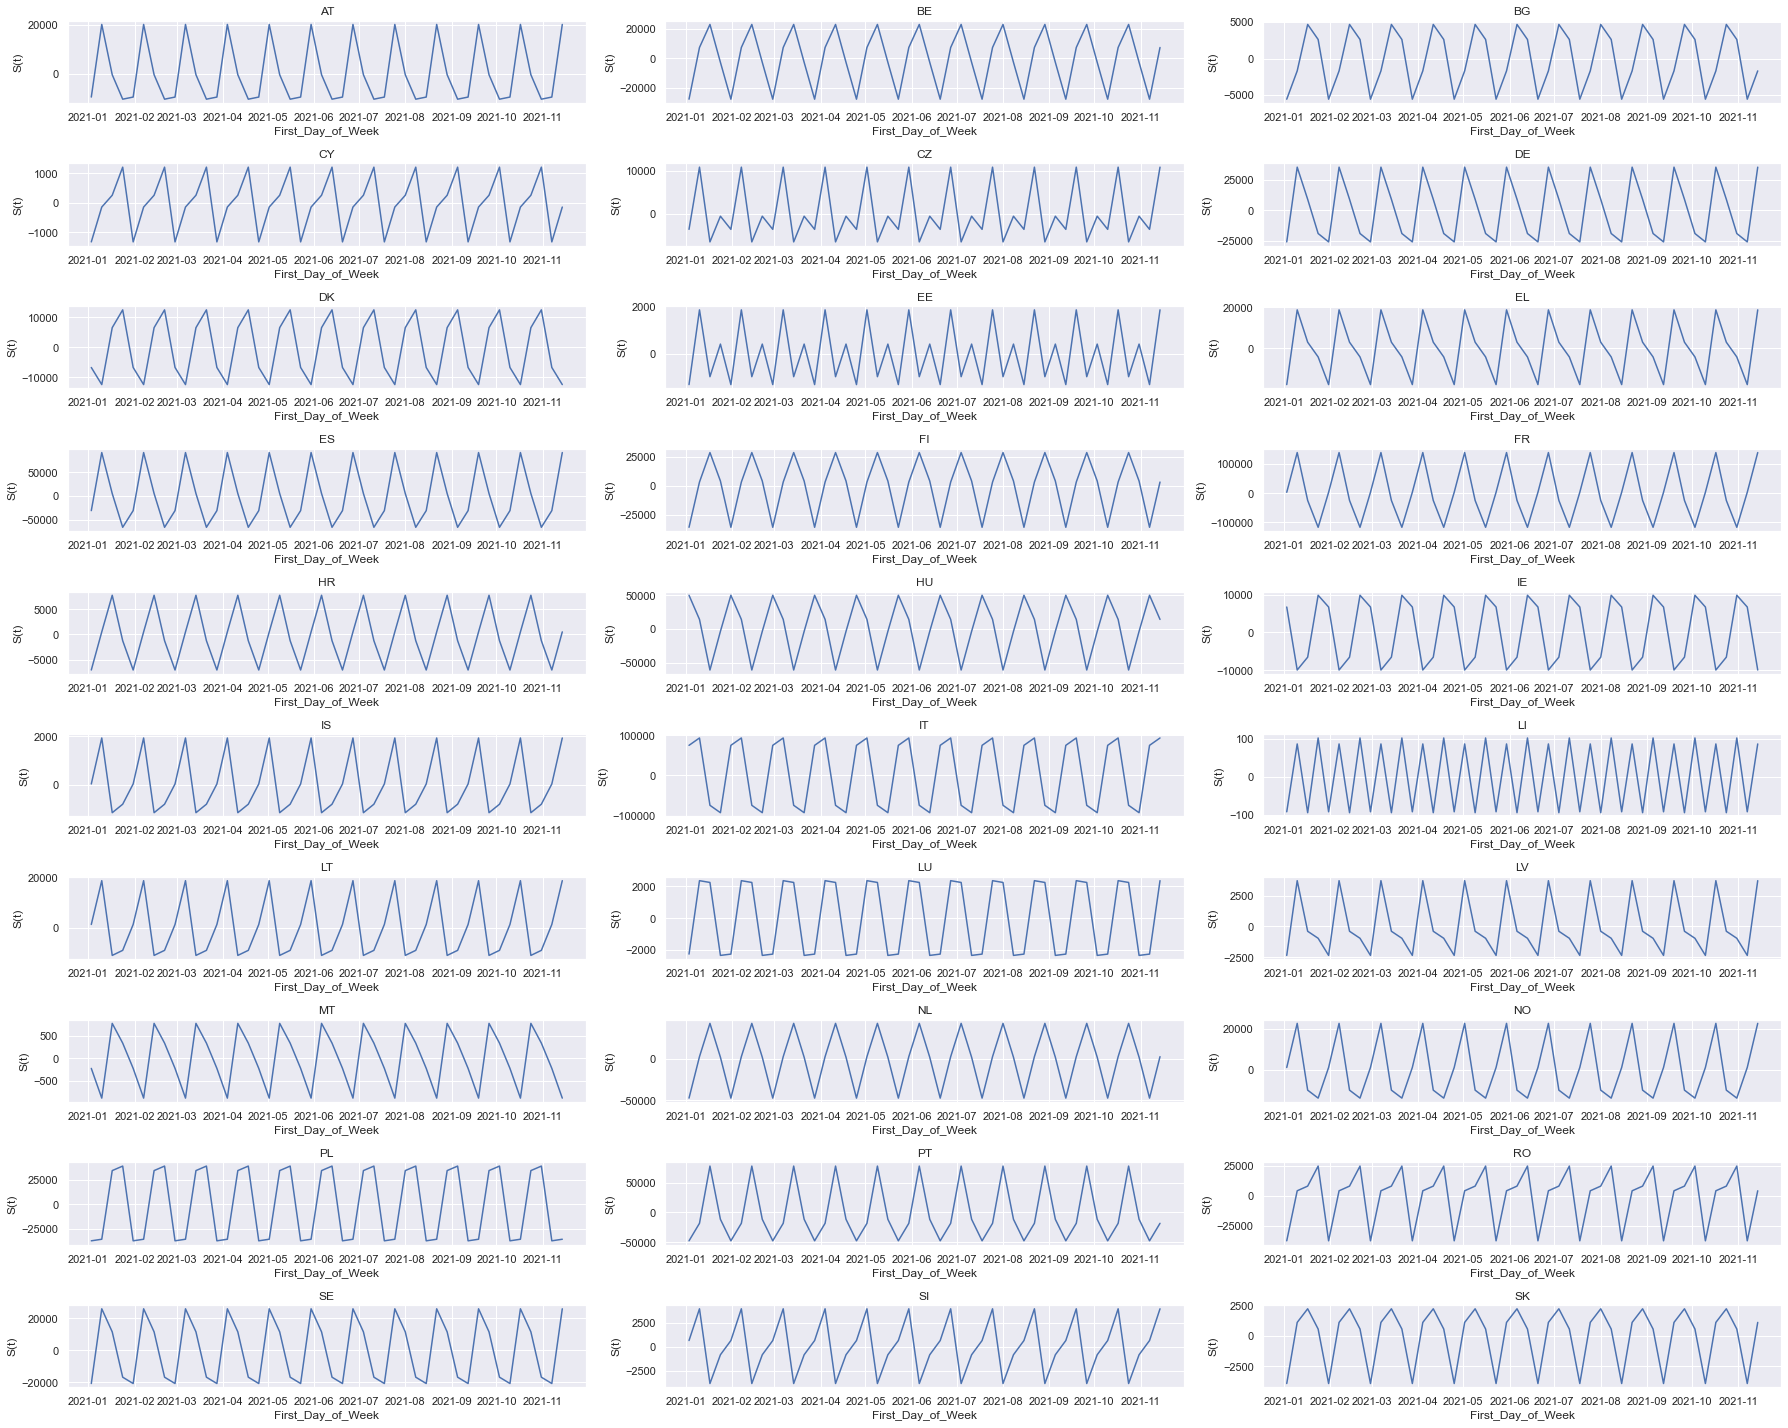

In [29]:
plt.figure(figsize=(25, 20))
plt.title('Seasonal Decomposition: Weekly Covid Doses per Country')

for i in range(30):
    plt.subplot(10, 3, i+1)
    sns.lineplot(x=EU_country_sea_decomp.index, y=EU_country_sea_decomp[EU_country_sea_decomp.columns[i]])
    plt.ylabel('S(t)')
    plt.title(EU_country_sea_decomp.columns[i])
    plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


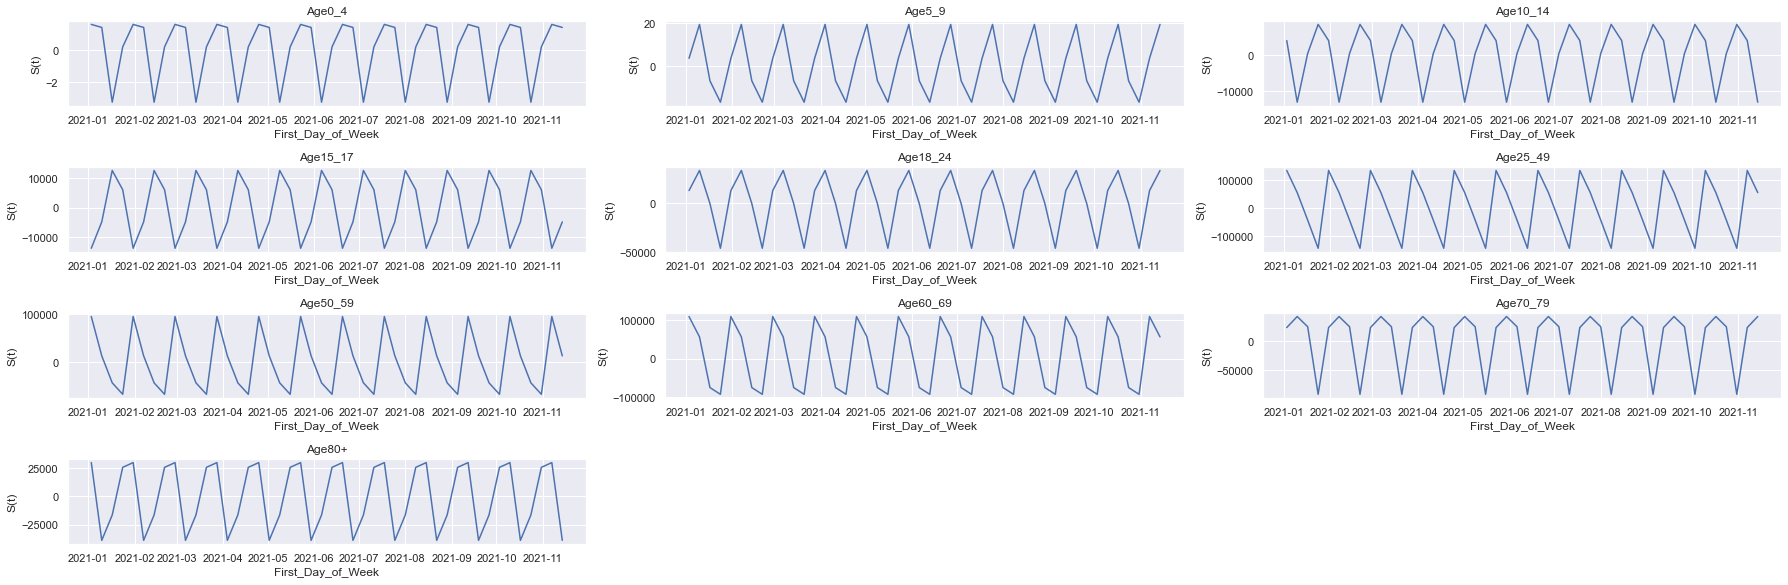

In [30]:
plt.figure(figsize=(25, 20))
plt.title('Seasonal Decomposition: Weekly Covid Doses per Country')

for i in range(10):
    plt.subplot(10, 3, i+1)
    sns.lineplot(x=EU_age_groups_sea_decomp.index, y=EU_age_groups_sea_decomp[EU_age_groups_sea_decomp.columns[i]])
    plt.ylabel('S(t)')
    plt.title(EU_age_groups_sea_decomp.columns[i])
    plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


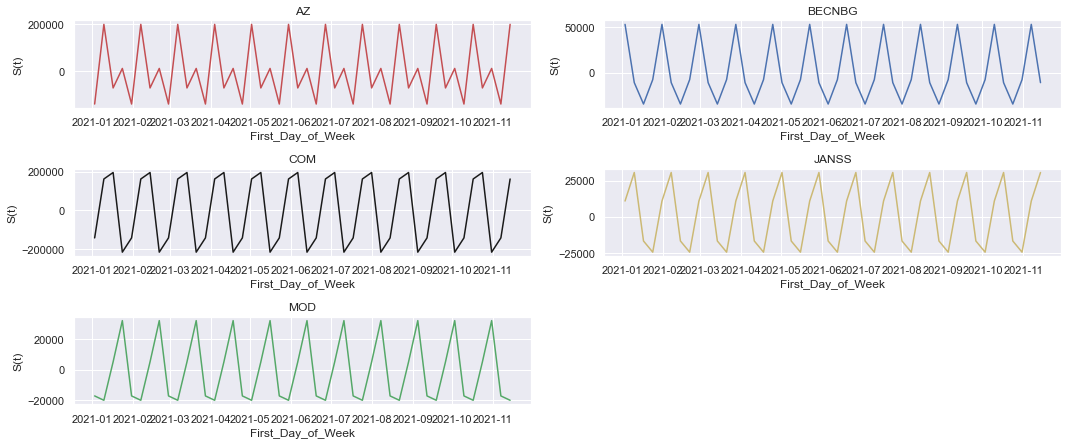

In [31]:

color_list = ['r','b','k','y','g']
plt.figure(figsize=(15, 10))
plt.title('Seasonal Decomposition: Weekly Covid Doses per Vaccine Manufacturer')

for i in range(5):
    plt.subplot(5, 2, i+1)
    sns.lineplot(x=EU_manufacturer_sea_decomp.index, y=EU_manufacturer_sea_decomp[EU_manufacturer_sea_decomp.columns[i]], color=color_list[i])
    plt.ylabel('S(t)')
    plt.title(EU_manufacturer_sea_decomp.columns[i])

    plt.tight_layout() # Or equivalently,  "plt.tight_layout()"


## Euclidean Distance
1. EU Countries + EU countries seasonal decomposition
2. EU Age Groups + EU Age Groups seasonal decomposition
3. EU Manufacturer + EU Manufacturer seasonal decomposition

In [32]:
def calc_euclidean_dist(input_df):
    dist_dict = {}
    for col1 in input_df.columns:
        distances = []
        for col2 in input_df.columns:
            distances.append(np.linalg.norm(input_df[col1] - input_df[col2]))
        dist_dict[col1] = distances

    output_df = pd.DataFrame(data=dist_dict, index=input_df.columns)
    return output_df

### 1. EU Countries + EU countries seasonal decomposition

In [33]:
calc_euclidean_dist(EU_country).head()

,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
Country,,,,,,,,,,,,,,,,,,,,,
AT,0.000000e+00,1.315178e+06,1.768686e+06,2.012980e+06,5.768187e+05,1.871902e+07,1.087052e+06,1.977725e+06,5.011683e+05,1.077952e+07,...,1.907537e+06,2.081000e+06,2.716089e+06,1.357134e+06,1.220588e+07,4.077315e+06,1.531664e+06,3.062778e+06,1.844334e+06,1.363180e+06
BE,1.315178e+06,0.000000e+00,2.781269e+06,2.985730e+06,1.086088e+06,1.774994e+07,1.703827e+06,2.964398e+06,1.057279e+06,9.759186e+06,...,2.898947e+06,3.064989e+06,1.628351e+06,2.128259e+06,1.121567e+07,3.157809e+06,2.359542e+06,2.270829e+06,2.847647e+06,2.361869e+06
BG,1.768686e+06,2.781269e+06,0.000000e+00,3.421834e+05,1.834516e+06,2.038768e+07,1.245567e+06,2.937725e+05,1.914830e+06,1.240205e+07,...,2.275688e+05,3.962832e+05,4.209347e+06,1.043499e+06,1.376400e+07,5.536124e+06,1.977332e+06,4.593952e+06,2.147787e+05,4.888496e+05
CY,2.012980e+06,2.985730e+06,3.421834e+05,0.000000e+00,2.059181e+06,2.063305e+07,1.403537e+06,1.004702e+05,2.156050e+06,1.262703e+07,...,1.841013e+05,1.067706e+05,4.401254e+06,1.216459e+06,1.398397e+07,5.758308e+06,2.261025e+06,4.833112e+06,2.157659e+05,6.861233e+05
CZ,5.768187e+05,1.086088e+06,1.834516e+06,2.059181e+06,0.000000e+00,1.861840e+07,8.991998e+05,2.029777e+06,4.766006e+05,1.063469e+07,...,1.963050e+06,2.134693e+06,2.466964e+06,1.245290e+06,1.204703e+07,3.918367e+06,1.703700e+06,2.920005e+06,1.910664e+06,1.404758e+06


In [34]:
calc_euclidean_dist(EU_country_sea_decomp).head()

,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
AT,0.000000,112644.815716,89773.407519,85069.613085,54023.041698,88025.069847,138075.088993,78215.781824,36851.965223,314189.826346,...,69578.424680,87382.684172,206748.221483,50462.479898,293206.933769,319905.735210,163595.636386,63230.526946,74335.592845,78300.826447
BE,112644.815716,0.000000,104775.071822,122528.097543,129993.331604,120457.384342,124859.512742,123609.449862,85192.364254,360852.463336,...,118511.281277,124645.007515,95971.823639,161630.180099,208209.281362,215243.548912,109546.910560,91844.432724,133696.840673,110674.304034
BG,89773.407519,104775.071822,0.000000,21938.733748,58829.843883,163487.627727,49876.813129,27782.706122,85133.068043,401131.144960,...,29941.663569,23932.382127,192001.838748,113499.879947,222617.017888,292358.390222,134566.124955,129447.117367,42078.432760,15468.025699
CY,85069.613085,122528.097543,21938.733748,0.000000,45678.002009,166289.762513,62984.520479,8443.508608,88445.497799,398043.187639,...,15724.223579,5680.274486,212349.735124,99290.727018,241851.851249,312276.168876,150446.640419,133529.250299,21839.868289,12068.591537
CZ,54023.041698,129993.331604,58829.843883,45678.002009,0.000000,139531.661100,101916.007613,37585.293241,64788.348619,364517.194816,...,32705.574480,49236.361876,224235.750649,62730.931253,273015.153442,336157.077690,153749.598755,113377.475226,29835.995179,45019.738832


In [35]:
maxValues = pd.DataFrame(calc_euclidean_dist(EU_country).max(axis = 1))
maxColumn = pd.DataFrame(calc_euclidean_dist(EU_country).idxmax(axis=1))
maxValues['country'] = maxColumn
maxValues.columns = ['max_euclidean', 'country']
maxValues.sort_values('max_euclidean', ascending=False)

,max_euclidean,country
Country,,
FR,3.290725e+07,LI
LI,3.290725e+07,FR
IS,3.281634e+07,FR
MT,3.278482e+07,FR
LU,3.277098e+07,FR
CY,3.270403e+07,FR
EE,3.267671e+07,FR
LV,3.260778e+07,FR
SI,3.255388e+07,FR


In [102]:
maxValues = pd.DataFrame(calc_euclidean_dist(EU_country_sea_decomp).max(axis = 1))
maxColumn = pd.DataFrame(calc_euclidean_dist(EU_country_sea_decomp).idxmax(axis=1))
maxValues['country'] = maxColumn
maxValues.columns = ['max_euclidean', 'country']
maxValues.sort_values('max_euclidean', ascending=False)

,max_euclidean,country
PL,830400.149479,FR
FR,830400.149479,PL
IT,816686.160363,PL
PT,808992.143781,IT
NL,724381.929664,IT
RO,686572.231523,IT
DK,686339.039696,FR
FI,680410.026924,IT
IE,668351.498817,FR
BE,638000.533917,IT


In [133]:
#smallest values
minValues = pd.DataFrame(calc_euclidean_dist(EU_country).apply(lambda row: row.nsmallest(2).values[-1],axis=1))
maxColumn = calc_euclidean_dist(EU_country).T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = maxColumn
minValues.columns = ['min_euc', 'country']
minValues.sort_values('min_euc').head()

,min_euc,country
Country,,
LU,73720.268895,IS
IS,73720.268895,LU
MT,81176.173222,LU
CY,100470.233662,EE
EE,100470.233662,CY


In [134]:
#smallest values
minValues = pd.DataFrame(calc_euclidean_dist(EU_country_sea_decomp).apply(lambda row: row.nsmallest(2).values[-1],axis=1))
maxColumn = calc_euclidean_dist(EU_country_sea_decomp).T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = maxColumn
minValues.columns = ['min_euc', 'country']
minValues.sort_values('min_euc').head()

,min_euc,country
MT,4552.559599,LI
LI,4552.559599,MT
CY,5680.274486,MT
EE,6165.993984,IS
IS,6165.993984,EE


### 2. EU Age Groups + EU Age Groups seasonal decomposition


In [36]:
calc_euclidean_dist(EU_age_groups).head()

,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
TargetGroup,,,,,,,,,,
Age0_4,0.000000e+00,4.032515e+03,1.497464e+06,1.720370e+06,1.015784e+07,4.313324e+07,2.076631e+07,1.952382e+07,1.611406e+07,1.031218e+07
Age5_9,4.032515e+03,0.000000e+00,1.496819e+06,1.719884e+06,1.015746e+07,4.313282e+07,2.076588e+07,1.952323e+07,1.611300e+07,1.031106e+07
Age10_14,1.497464e+06,1.496819e+06,0.000000e+00,5.328737e+05,9.073778e+06,4.226315e+07,2.029444e+07,1.919101e+07,1.591818e+07,1.015725e+07
Age15_17,1.720370e+06,1.719884e+06,5.328737e+05,0.000000e+00,8.643453e+06,4.184887e+07,1.996848e+07,1.894302e+07,1.580536e+07,1.015004e+07
Age18_24,1.015784e+07,1.015746e+07,9.073778e+06,8.643453e+06,0.000000e+00,3.360795e+07,1.474332e+07,1.549473e+07,1.527942e+07,1.253859e+07


In [37]:
calc_euclidean_dist(EU_age_groups_sea_decomp).head()

,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
Age0_4,0.000000,84.516463,55465.590222,69173.826250,197773.247960,706174.760174,424364.128383,582527.479560,355593.157659,196549.322669
Age5_9,84.516463,0.000000,55543.553342,69217.408998,197691.787847,706113.379089,424318.839395,582467.519506,355521.203193,196608.670360
Age10_14,55465.590222,55543.553342,0.000000,79982.171939,245446.217005,730451.932570,437172.782117,606492.033149,396914.298612,148263.850346
Age15_17,69173.826250,69217.408998,79982.171939,0.000000,241829.978513,765429.775222,488989.844702,648652.572659,386415.669513,223437.365560
Age18_24,197773.247960,197691.787847,245446.217005,241829.978513,0.000000,552492.138981,332413.655657,451285.376610,177397.101570,354286.837996


In [38]:
maxValues = pd.DataFrame(calc_euclidean_dist(EU_age_groups).max(axis = 1))
maxColumn = pd.DataFrame(calc_euclidean_dist(EU_age_groups).idxmax(axis=1))
maxValues['age group'] = maxColumn
maxValues.columns = ['max_euclidean', 'age group']
maxValues.sort_values('max_euclidean', ascending=False)

,max_euclidean,age group
TargetGroup,,
Age0_4,4.313324e+07,Age25_49
Age25_49,4.313324e+07,Age0_4
Age5_9,4.313282e+07,Age25_49
Age10_14,4.226315e+07,Age25_49
Age15_17,4.184887e+07,Age25_49
Age80+,4.079675e+07,Age25_49
Age70_79,3.705828e+07,Age25_49
Age18_24,3.360795e+07,Age25_49
Age60_69,3.049695e+07,Age25_49


In [103]:
maxValues = pd.DataFrame(calc_euclidean_dist(EU_age_groups_sea_decomp).max(axis = 1))
maxColumn = pd.DataFrame(calc_euclidean_dist(EU_age_groups_sea_decomp).idxmax(axis=1))
maxValues['age group'] = maxColumn
maxValues.columns = ['max_euclidean', 'age group']
maxValues.sort_values('max_euclidean', ascending=False)

,max_euclidean,age group
Age15_17,765429.775222,Age25_49
Age25_49,765429.775222,Age15_17
Age80+,747003.345297,Age25_49
Age10_14,730451.932570,Age25_49
Age0_4,706174.760174,Age25_49
Age5_9,706113.379089,Age25_49
Age60_69,648652.572659,Age15_17
Age18_24,552492.138981,Age25_49
Age70_79,497817.419775,Age80+
Age50_59,488989.844702,Age15_17


In [135]:
#smallest values
minValues = pd.DataFrame(calc_euclidean_dist(EU_age_groups).apply(lambda row: row.nsmallest(2).values[-1],axis=1))
maxColumn = calc_euclidean_dist(EU_age_groups).T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = maxColumn
minValues.columns = ['min_euc', 'age group']
minValues.sort_values('min_euc').head()

,min_euc,age group
TargetGroup,,
Age0_4,4.032515e+03,Age5_9
Age5_9,4.032515e+03,Age0_4
Age10_14,5.328737e+05,Age15_17
Age15_17,5.328737e+05,Age10_14
Age50_59,7.998116e+06,Age60_69


In [136]:
#smallest values
minValues = pd.DataFrame(calc_euclidean_dist(EU_age_groups_sea_decomp).apply(lambda row: row.nsmallest(2).values[-1],axis=1))
maxColumn = calc_euclidean_dist(EU_age_groups_sea_decomp).T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = maxColumn
minValues.columns = ['min_euc', 'age group']
minValues.sort_values('min_euc').head()

,min_euc,age group
Age0_4,84.516463,Age5_9
Age5_9,84.516463,Age0_4
Age10_14,55465.590222,Age0_4
Age15_17,69173.826250,Age0_4
Age80+,148263.850346,Age10_14


### 3. EU Manufacturer + EU Manufacturer seasonal decomposition

In [39]:
calc_euclidean_dist(EU_manufacturer)

,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
Vaccine,,,,,,,
AZ,0.000000e+00,1.854263e+07,8.287619e+07,1.627848e+07,1.084322e+07,1.854117e+07,9.741088e+06
BECNBG,1.854263e+07,0.000000e+00,9.845065e+07,4.588012e+06,1.471539e+07,5.403386e+05,1.614611e+07
COM,8.287619e+07,9.845065e+07,0.000000e+00,9.450700e+07,8.417758e+07,9.847537e+07,8.256666e+07
JANSS,1.627848e+07,4.588012e+06,9.450700e+07,0.000000e+00,1.082747e+07,4.684468e+06,1.236799e+07
MOD,1.084322e+07,1.471539e+07,8.417758e+07,1.082747e+07,0.000000e+00,1.474392e+07,2.739834e+06
SPU,1.854117e+07,5.403386e+05,9.847537e+07,4.684468e+06,1.474392e+07,0.000000e+00,1.617105e+07
UNK,9.741088e+06,1.614611e+07,8.256666e+07,1.236799e+07,2.739834e+06,1.617105e+07,0.000000e+00


In [40]:
calc_euclidean_dist(EU_manufacturer_sea_decomp)

,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
AZ,0.000000e+00,9.934782e+05,1.165010e+06,8.083300e+05,9.042538e+05,8.329972e+05,7.263157e+05
BECNBG,9.934782e+05,0.000000e+00,1.364758e+06,2.208832e+05,3.081927e+05,2.439316e+05,3.785426e+05
COM,1.165010e+06,1.364758e+06,0.000000e+00,1.172726e+06,1.283504e+06,1.160233e+06,1.043398e+06
JANSS,8.083300e+05,2.208832e+05,1.172726e+06,0.000000e+00,2.838780e+05,1.001561e+05,1.788333e+05
MOD,9.042538e+05,3.081927e+05,1.283504e+06,2.838780e+05,0.000000e+00,2.013153e+05,4.398013e+05
SPU,8.329972e+05,2.439316e+05,1.160233e+06,1.001561e+05,2.013153e+05,0.000000e+00,2.449184e+05
UNK,7.263157e+05,3.785426e+05,1.043398e+06,1.788333e+05,4.398013e+05,2.449184e+05,0.000000e+00


In [41]:
maxValues = pd.DataFrame(calc_euclidean_dist(EU_manufacturer).max(axis = 1))
maxColumn = pd.DataFrame(calc_euclidean_dist(EU_manufacturer).idxmax(axis=1))
maxValues['manu'] = maxColumn
maxValues.columns = ['max_euclidean', 'manu']
maxValues.sort_values('max_euclidean', ascending=False)

,max_euclidean,manu
Vaccine,,
COM,9.847537e+07,SPU
SPU,9.847537e+07,COM
BECNBG,9.845065e+07,COM
JANSS,9.450700e+07,COM
MOD,8.417758e+07,COM
AZ,8.287619e+07,COM
UNK,8.256666e+07,COM


In [104]:
maxValues = pd.DataFrame(calc_euclidean_dist(EU_manufacturer_sea_decomp).max(axis = 1))
maxColumn = pd.DataFrame(calc_euclidean_dist(EU_manufacturer_sea_decomp).idxmax(axis=1))
maxValues['manu'] = maxColumn
maxValues.columns = ['max_euclidean', 'manu']
maxValues.sort_values('max_euclidean', ascending=False)

,max_euclidean,manu
BECNBG,1.364758e+06,COM
COM,1.364758e+06,BECNBG
MOD,1.283504e+06,COM
JANSS,1.172726e+06,COM
AZ,1.165010e+06,COM
SPU,1.160233e+06,COM
UNK,1.043398e+06,COM


In [137]:
#smallest values
minValues = pd.DataFrame(calc_euclidean_dist(EU_manufacturer).apply(lambda row: row.nsmallest(2).values[-1],axis=1))
maxColumn = calc_euclidean_dist(EU_manufacturer).T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = maxColumn
minValues.columns = ['min_euc', 'manu']
minValues.sort_values('min_euc').head()

,min_euc,manu
Vaccine,,
BECNBG,5.403386e+05,SPU
SPU,5.403386e+05,BECNBG
MOD,2.739834e+06,UNK
UNK,2.739834e+06,MOD
JANSS,4.588012e+06,BECNBG


In [138]:
#smallest values
minValues = pd.DataFrame(calc_euclidean_dist(EU_manufacturer_sea_decomp).apply(lambda row: row.nsmallest(2).values[-1],axis=1))
maxColumn = calc_euclidean_dist(EU_manufacturer_sea_decomp).T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = maxColumn
minValues.columns = ['min_euc', 'manu']
minValues.sort_values('min_euc').head()

,min_euc,manu
JANSS,100156.077569,SPU
SPU,100156.077569,JANSS
UNK,178833.272857,JANSS
MOD,201315.275623,SPU
BECNBG,220883.218398,JANSS


## Cosine Similarity
1. EU Countries + EU countries seasonal decomposition
2. EU Age Groups + EU Age Groups seasonal decomposition
3. EU Manufacturer + EU Manufacturer seasonal decomposition

In [42]:
def calc_cos_sim(input_df):
    from scipy.spatial.distance import cosine
    
    dist_dict = {}
    for col1 in input_df.columns:
        distances = []
        for col2 in input_df.columns:
            distances.append(1 - cosine(input_df[col1], input_df[col2]))
        dist_dict[col1] = distances

    output_df = pd.DataFrame(data=dist_dict, index=input_df.columns)
    return output_df

### 1. EU Countries + EU countries seasonal decomposition


In [43]:
calc_cos_sim(EU_country).head()

,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
Country,,,,,,,,,,,,,,,,,,,,,
AT,1.000000,0.945194,0.886516,0.917548,0.967250,0.965014,0.886849,0.942093,0.978381,0.938582,...,0.880522,0.892098,0.918687,0.811391,0.914267,0.901268,0.786487,0.936334,0.942195,0.970932
BE,0.945194,1.000000,0.816654,0.928059,0.977596,0.975137,0.962876,0.901443,0.970900,0.971818,...,0.835444,0.840526,0.977895,0.853479,0.948785,0.939267,0.679132,0.945553,0.878254,0.946530
BG,0.886516,0.816654,1.000000,0.887496,0.864020,0.882631,0.772656,0.948635,0.895535,0.828192,...,0.935324,0.882165,0.783213,0.780304,0.835880,0.823849,0.885789,0.860727,0.927708,0.893914
CY,0.917548,0.928059,0.887496,1.000000,0.938829,0.963077,0.910930,0.922273,0.958344,0.918618,...,0.906141,0.909686,0.921534,0.842297,0.959926,0.903029,0.761893,0.915066,0.915144,0.953999
CZ,0.967250,0.977596,0.864020,0.938829,1.000000,0.985218,0.949555,0.940258,0.979880,0.974445,...,0.870646,0.879147,0.970566,0.875078,0.956828,0.936286,0.739159,0.962504,0.911220,0.977399


In [44]:
calc_cos_sim(EU_country_sea_decomp).head()

,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
AT,1.000000,0.485528,-0.040681,-0.043588,0.818939,0.965623,-0.645165,0.763928,0.913514,0.980483,...,0.968366,-0.644287,0.306983,0.852336,-0.427366,0.074952,0.183529,0.931811,0.618505,0.473141
BE,0.485528,1.000000,0.831952,0.589017,0.092655,0.694831,0.285061,0.314933,0.737265,0.430276,...,0.530276,0.344094,0.980811,-0.039052,0.538241,0.865807,0.719048,0.752371,-0.339128,0.967522
BG,-0.040681,0.831952,1.000000,0.840308,-0.272098,0.206517,0.768345,0.048964,0.341043,-0.132932,...,0.080794,0.726721,0.919585,-0.555298,0.914874,0.853166,0.842853,0.270112,-0.674056,0.859026
CY,-0.043588,0.589017,0.840308,1.000000,0.046550,0.118842,0.748598,0.380997,0.358636,-0.214739,...,0.177244,0.450838,0.667280,-0.450047,0.828094,0.439475,0.972889,0.114266,-0.332207,0.749099
CZ,0.818939,0.092655,-0.272098,0.046550,1.000000,0.688177,-0.612310,0.940551,0.735421,0.734869,...,0.878356,-0.854605,-0.069920,0.846010,-0.511084,-0.409483,0.203631,0.589477,0.892527,0.208250


In [139]:
maxValues = pd.DataFrame(calc_cos_sim(EU_country).apply(lambda row: row.nlargest(2).values[-1],axis=1))
maxColumn = calc_cos_sim(EU_country).T.apply(lambda x: x.nlargest(2).idxmin())
maxValues['country'] = maxColumn
maxValues.columns = ['max_cos', 'country']
maxValues.sort_values('max_cos', ascending=False).head()

,max_cos,country
Country,,
FR,0.988743,IT
IT,0.988743,FR
FI,0.986485,FR
CZ,0.985218,DE
DE,0.985218,CZ


In [142]:
maxValues = pd.DataFrame(calc_cos_sim(EU_country_sea_decomp).apply(lambda row: row.nlargest(2).values[-1],axis=1))
maxColumn = calc_cos_sim(EU_country_sea_decomp).T.apply(lambda x: x.nlargest(2).idxmin())
maxValues['country'] = maxColumn
maxValues.columns = ['max_cos', 'country']
maxValues.sort_values('max_cos', ascending=False).head()

,max_cos,country
IS,0.997906,LT
LT,0.997906,IS
FI,0.996210,NL
NL,0.996210,FI
SE,0.991703,DE


In [145]:
minValues = pd.DataFrame(calc_cos_sim(EU_country).min(axis = 1))
minColumn = pd.DataFrame(calc_cos_sim(EU_country).idxmin(axis=1))
minValues['manu'] = minColumn
minValues.columns = ['min cos', 'country']
minValues.sort_values('min cos').head()

,min cos,country
Country,,
NO,0.565944,RO
RO,0.565944,NO
DK,0.597859,RO
PT,0.631791,RO
NL,0.633742,RO


In [146]:
minValues = pd.DataFrame(calc_cos_sim(EU_country_sea_decomp).min(axis = 1))
minColumn = pd.DataFrame(calc_cos_sim(EU_country_sea_decomp).idxmin(axis=1))
minValues['manu'] = minColumn
minValues.columns = ['min cos', 'country']
minValues.sort_values('min cos').head()

,min cos,country
IT,-0.995021,PL
PL,-0.995021,IT
MT,-0.988975,SI
SI,-0.988975,MT
LU,-0.985045,IE


### 2. EU Age Groups + EU Age Groups seasonal decomposition


In [46]:
calc_cos_sim(EU_age_groups).head()

,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
TargetGroup,,,,,,,,,,
Age0_4,1.000000,0.632382,0.747488,0.773842,0.776484,0.747047,0.621361,0.586903,0.533357,0.477248
Age5_9,0.632382,1.000000,0.213232,0.177569,0.153417,0.158232,0.150395,0.187806,0.294496,0.302581
Age10_14,0.747488,0.213232,1.000000,0.954548,0.759067,0.592611,0.347679,0.258805,0.176582,0.175395
Age15_17,0.773842,0.177569,0.954548,1.000000,0.899353,0.755424,0.496324,0.376708,0.231184,0.177010
Age18_24,0.776484,0.153417,0.759067,0.899353,1.000000,0.951937,0.751534,0.615872,0.395245,0.249706


In [47]:
calc_cos_sim(EU_age_groups_sea_decomp).head()

,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
Age0_4,1.000000,0.509559,-0.195837,-0.872968,0.283056,0.512492,0.620124,0.728408,0.017816,0.215582
Age5_9,0.509559,1.000000,-0.890404,-0.607489,0.941830,0.752822,0.590390,0.768234,0.798477,-0.625213
Age10_14,-0.195837,-0.890404,1.000000,0.190623,-0.822840,-0.405848,-0.168928,-0.393186,-0.710317,0.904781
Age15_17,-0.872968,-0.607489,0.190623,1.000000,-0.533038,-0.843622,-0.923930,-0.950831,-0.367715,-0.239372
Age18_24,0.283056,0.941830,-0.822840,-0.533038,1.000000,0.832557,0.647607,0.758627,0.953335,-0.614438


In [48]:
maxValues = pd.DataFrame(calc_cos_sim(EU_age_groups).apply(lambda row: row.nlargest(2).values[-1],axis=1))
maxColumn = calc_cos_sim(EU_age_groups).T.apply(lambda x: x.nlargest(2).idxmin())
maxValues['age group'] = maxColumn
maxValues.columns = ['max_cos', 'age group']
maxValues.sort_values('max_cos', ascending=False)

,max_cos,age group
TargetGroup,,
Age10_14,0.954548,Age15_17
Age15_17,0.954548,Age10_14
Age18_24,0.951937,Age25_49
Age25_49,0.951937,Age18_24
Age50_59,0.923016,Age60_69
Age60_69,0.923016,Age50_59
Age70_79,0.907185,Age60_69
Age80+,0.831095,Age70_79
Age0_4,0.776484,Age18_24


In [106]:
maxValues = pd.DataFrame(calc_cos_sim(EU_age_groups_sea_decomp).apply(lambda row: row.nlargest(2).values[-1],axis=1))
maxColumn = calc_cos_sim(EU_age_groups_sea_decomp).T.apply(lambda x: x.nlargest(2).idxmin())
maxValues['age group'] = maxColumn
maxValues.columns = ['max_cos', 'age group']
maxValues.sort_values('max_cos', ascending=False)

,max_cos,age group
Age50_59,0.961854,Age60_69
Age60_69,0.961854,Age50_59
Age25_49,0.961596,Age60_69
Age18_24,0.953335,Age70_79
Age70_79,0.953335,Age18_24
Age5_9,0.941830,Age18_24
Age10_14,0.904781,Age80+
Age80+,0.904781,Age10_14
Age0_4,0.728408,Age60_69
Age15_17,0.190623,Age10_14


In [149]:
minValues = pd.DataFrame(calc_cos_sim(EU_age_groups).min(axis = 1))
minColumn = pd.DataFrame(calc_cos_sim(EU_age_groups).idxmin(axis=1))
minValues['manu'] = minColumn
minValues.columns = ['min cos', 'age group']
minValues.sort_values('min cos').head()

,min cos,age group
TargetGroup,,
Age5_9,0.150395,Age50_59
Age50_59,0.150395,Age5_9
Age18_24,0.153417,Age5_9
Age25_49,0.158232,Age5_9
Age10_14,0.175395,Age80+


In [150]:
minValues = pd.DataFrame(calc_cos_sim(EU_age_groups_sea_decomp).min(axis = 1))
minColumn = pd.DataFrame(calc_cos_sim(EU_age_groups_sea_decomp).idxmin(axis=1))
minValues['manu'] = minColumn
minValues.columns = ['min cos', 'age group']
minValues.sort_values('min cos').head()

,min cos,age group
Age15_17,-0.950831,Age60_69
Age60_69,-0.950831,Age15_17
Age50_59,-0.923930,Age15_17
Age5_9,-0.890404,Age10_14
Age10_14,-0.890404,Age5_9


### 3. EU Manufacturer + EU Manufacturer seasonal decomposition

In [49]:
calc_cos_sim(EU_manufacturer)

,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
Vaccine,,,,,,,
AZ,1.000000,0.651286,0.867424,0.644214,0.820552,0.723544,0.857788
BECNBG,0.651286,1.000000,0.514239,0.381351,0.478149,0.597533,0.504799
COM,0.867424,0.514239,1.000000,0.895489,0.976738,0.527960,0.987397
JANSS,0.644214,0.381351,0.895489,1.000000,0.910409,0.245590,0.892710
MOD,0.820552,0.478149,0.976738,0.910409,1.000000,0.478084,0.989050
SPU,0.723544,0.597533,0.527960,0.245590,0.478084,1.000000,0.514331
UNK,0.857788,0.504799,0.987397,0.892710,0.989050,0.514331,1.000000


In [50]:
calc_cos_sim(EU_manufacturer_sea_decomp)

,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
AZ,1.000000,-0.459724,0.415676,0.495419,-0.152598,0.588110,0.606964
BECNBG,-0.459724,1.000000,-0.621464,0.342328,-0.413731,-0.180939,0.020504
COM,0.415676,-0.621464,1.000000,0.345248,-0.433965,0.813297,0.642684
JANSS,0.495419,0.342328,0.345248,1.000000,-0.907893,0.825630,0.938344
MOD,-0.152598,-0.413731,-0.433965,-0.907893,1.000000,-0.806277,-0.869728
SPU,0.588110,-0.180939,0.813297,0.825630,-0.806277,1.000000,0.968399
UNK,0.606964,0.020504,0.642684,0.938344,-0.869728,0.968399,1.000000


In [51]:
maxValues = pd.DataFrame(calc_cos_sim(EU_manufacturer).apply(lambda row: row.nlargest(2).values[-1],axis=1))
maxColumn = calc_cos_sim(EU_manufacturer).T.apply(lambda x: x.nlargest(2).idxmin())
maxValues['manu'] = maxColumn
maxValues.columns = ['max_cos', 'manu']
maxValues.sort_values('max_cos', ascending=False)

,max_cos,manu
Vaccine,,
MOD,0.989050,UNK
UNK,0.989050,MOD
COM,0.987397,UNK
JANSS,0.910409,MOD
AZ,0.867424,COM
SPU,0.723544,AZ
BECNBG,0.651286,AZ


In [107]:
maxValues = pd.DataFrame(calc_cos_sim(EU_manufacturer_sea_decomp).apply(lambda row: row.nlargest(2).values[-1],axis=1))
maxColumn = calc_cos_sim(EU_manufacturer_sea_decomp).T.apply(lambda x: x.nlargest(2).idxmin())
maxValues['manu'] = maxColumn
maxValues.columns = ['max_cos', 'manu']
maxValues.sort_values('max_cos', ascending=False)

,max_cos,manu
SPU,0.968399,UNK
UNK,0.968399,SPU
JANSS,0.938344,UNK
COM,0.813297,SPU
AZ,0.606964,UNK
BECNBG,0.342328,JANSS
MOD,-0.152598,AZ


In [151]:
minValues = pd.DataFrame(calc_cos_sim(EU_manufacturer).min(axis = 1))
minColumn = pd.DataFrame(calc_cos_sim(EU_manufacturer).idxmin(axis=1))
minValues['manu'] = minColumn
minValues.columns = ['min cos', 'manu']
minValues.sort_values('min cos').head()

,min cos,manu
Vaccine,,
JANSS,0.245590,SPU
SPU,0.245590,JANSS
BECNBG,0.381351,JANSS
MOD,0.478084,SPU
UNK,0.504799,BECNBG


In [152]:
minValues = pd.DataFrame(calc_cos_sim(EU_manufacturer_sea_decomp).min(axis = 1))
minColumn = pd.DataFrame(calc_cos_sim(EU_manufacturer_sea_decomp).idxmin(axis=1))
minValues['manu'] = minColumn
minValues.columns = ['min cos', 'manu']
minValues.sort_values('min cos').head()

,min cos,manu
JANSS,-0.907893,MOD
MOD,-0.907893,JANSS
UNK,-0.869728,MOD
SPU,-0.806277,MOD
BECNBG,-0.621464,COM


## DTW Cost
1. EU Countries + EU countries seasonal decomposition
2. EU Age Groups + EU Age Groups seasonal decomposition
3. EU Manufacturer + EU Manufacturer seasonal decomposition

In [53]:
from dtaidistance import dtw

def calc_dtw_cost(input_df):
    
    dist_dict = {}
    for col1 in input_df.columns:
        distances = []
        for col2 in input_df.columns:
            distances.append(dtw.distance(input_df[col1], input_df[col2])**2)
        dist_dict[col1] = distances

    output_df = pd.DataFrame(data=dist_dict, index=input_df.columns)
    return output_df

### 1. EU Countries + EU countries seasonal decomposition


In [54]:
dtw_country = calc_dtw_cost(EU_country)
dtw_country.head()

,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
Country,,,,,,,,,,,,,,,,,,,,,
AT,0.000000e+00,8.407378e+11,1.937599e+12,3.431900e+12,2.651781e+11,3.042242e+14,7.521590e+11,3.527863e+12,1.229221e+11,9.411061e+13,...,2.821767e+12,3.947497e+12,4.978733e+12,8.519269e+11,1.275735e+14,9.352817e+12,3.846361e+11,4.412236e+12,2.517122e+12,1.329439e+12
BE,8.407378e+11,0.000000e+00,5.586372e+12,7.892868e+12,4.830540e+11,2.492767e+14,1.578762e+12,8.139687e+12,5.078900e+11,6.196966e+13,...,7.015129e+12,8.704496e+12,9.288534e+11,1.855840e+12,8.939852e+13,2.352174e+12,9.748414e+11,9.180981e+11,6.575627e+12,4.328558e+12
BG,1.937599e+12,5.586372e+12,0.000000e+00,6.772670e+10,2.034619e+12,4.073791e+14,7.313670e+11,5.068668e+10,2.389113e+12,1.431076e+14,...,2.231933e+10,1.056959e+11,1.436041e+13,3.866706e+11,1.790344e+14,2.539690e+13,2.765180e+12,1.713471e+13,1.200539e+10,4.159194e+10
CY,3.431900e+12,7.892868e+12,6.772670e+10,0.000000e+00,3.519447e+12,4.240107e+14,1.497907e+12,3.821092e+09,4.045484e+12,1.556868e+14,...,2.221196e+10,2.973350e+09,1.784381e+13,9.756327e+11,1.923430e+14,3.086087e+13,4.410567e+12,2.184899e+13,2.003792e+10,2.778275e+11
CZ,2.651781e+11,4.830540e+11,2.034619e+12,3.519447e+12,0.000000e+00,3.099932e+14,3.329380e+11,3.679858e+12,1.407966e+11,9.134069e+13,...,2.935939e+12,4.068527e+12,3.816818e+12,4.359374e+11,1.223066e+14,8.121395e+12,7.804462e+11,3.759188e+12,2.641487e+12,1.333243e+12


In [55]:
dtw_country_sea_decomp = calc_dtw_cost(EU_country_sea_decomp)
dtw_country_sea_decomp.head()

,AT,BE,BG,CY,CZ,DE,DK,EE,EL,ES,...,LV,MT,NL,NO,PL,PT,RO,SE,SI,SK
AT,0.000000e+00,6.786497e+09,4.178969e+09,6.652184e+09,2.362251e+09,7.748413e+09,4.351222e+09,5.751412e+09,1.358067e+09,9.871525e+10,...,4.579443e+09,6.520765e+09,2.400714e+10,2.546462e+09,3.880778e+10,5.694553e+10,1.987445e+10,3.998100e+09,5.525780e+09,5.287718e+09
BE,6.786497e+09,0.000000e+00,1.097782e+10,1.496196e+10,8.985035e+09,1.358920e+10,5.125907e+09,1.390542e+10,3.383988e+09,8.936911e+10,...,1.216700e+10,1.495610e+10,9.210591e+09,4.279240e+09,2.620651e+10,4.632979e+10,9.592704e+09,8.435400e+09,1.245043e+10,1.224880e+10
BG,4.178969e+09,1.097782e+10,0.000000e+00,4.412281e+08,1.420123e+09,2.125988e+10,2.487696e+09,4.075535e+08,5.632729e+09,1.399095e+11,...,3.687618e+08,5.727589e+08,3.686471e+10,6.193588e+09,4.955834e+10,8.547343e+10,1.810804e+10,1.260129e+10,2.059751e+08,2.392598e+08
CY,6.652184e+09,1.496196e+10,4.412281e+08,0.000000e+00,1.662605e+09,2.681766e+10,3.967050e+09,4.209711e+07,7.631652e+09,1.547265e+11,...,1.811447e+08,3.226552e+07,4.428057e+10,8.083216e+09,5.849232e+10,9.683140e+10,2.263419e+10,1.706538e+10,1.814209e+08,1.224968e+08
CZ,2.362251e+09,8.985035e+09,1.420123e+09,1.662605e+09,0.000000e+00,1.842108e+10,2.026809e+09,1.412654e+09,3.933300e+09,1.289484e+11,...,1.069655e+09,1.905536e+09,3.252959e+10,2.620912e+09,5.229683e+10,7.655208e+10,1.477191e+10,1.036372e+10,8.901866e+08,1.680136e+09


In [153]:
maxValues = pd.DataFrame(dtw_country.max(axis = 1))
maxColumn = pd.DataFrame(dtw_country.idxmax(axis=1))
maxValues['country'] = maxColumn
maxValues.columns = ['max_dtw', 'country']
maxValues.sort_values('max_dtw', ascending=False).head()

,max_dtw,country
Country,,
FR,1.082887e+15,LI
LI,1.082887e+15,FR
MT,1.073068e+15,FR
IS,1.072353e+15,FR
LU,1.070767e+15,FR


In [154]:
maxValues = pd.DataFrame(dtw_country_sea_decomp.max(axis = 1))
maxColumn = pd.DataFrame(dtw_country_sea_decomp.idxmax(axis=1))
maxValues['country'] = maxColumn
maxValues.columns = ['max_dtw', 'country']
maxValues.sort_values('max_dtw', ascending=False).head()

,max_dtw,country
FR,3.886232e+11,LI
LI,3.886232e+11,FR
MT,3.859327e+11,FR
CY,3.815506e+11,FR
EE,3.801785e+11,FR


In [155]:
#smallest values
minValues = pd.DataFrame(dtw_country.apply(lambda row: row.nsmallest(2).values[-1],axis=1))
minColumn = dtw_country.T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = minColumn
minValues.columns = ['min_dtw', 'country']
minValues.sort_values('min_dtw').head()

,min_euc,country
Country,,
MT,7.399429e+08,LU
LU,7.399429e+08,MT
IS,2.046967e+09,LU
CY,2.973350e+09,MT
EE,3.821092e+09,CY


In [156]:
#smallest values
minValues = pd.DataFrame(dtw_country_sea_decomp.apply(lambda row: row.nsmallest(2).values[-1],axis=1))
minColumn = dtw_country_sea_decomp.T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = minColumn
minValues.columns = ['min_dtw', 'country']
minValues.sort_values('min_dtw').head()

,min_euc,country
MT,1.490197e+07,LI
LI,1.490197e+07,MT
CY,1.603241e+07,IS
IS,1.603241e+07,CY
EE,2.359995e+07,IS


### 2. EU Age Groups + EU Age Groups seasonal decomposition


In [57]:
dtw_age = calc_dtw_cost(EU_age_groups)
dtw_age

,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
TargetGroup,,,,,,,,,,
Age0_4,0.000000e+00,1.585219e+07,2.241524e+12,2.958554e+12,1.031818e+14,1.860476e+15,4.312396e+14,3.811797e+14,2.596631e+14,1.063411e+14
Age5_9,1.585219e+07,0.000000e+00,2.197086e+12,2.903599e+12,1.029092e+14,1.860440e+15,4.312219e+14,3.811564e+14,2.594352e+14,1.063180e+14
Age10_14,2.241524e+12,2.197086e+12,0.000000e+00,5.838546e+10,5.461533e+13,1.627612e+15,3.272539e+14,2.778923e+14,1.799693e+14,6.073115e+13
Age15_17,2.958554e+12,2.903599e+12,5.838546e+10,0.000000e+00,5.408690e+13,1.623675e+15,3.250868e+14,2.763825e+14,1.792795e+14,6.035292e+13
Age18_24,1.031818e+14,1.029092e+14,5.461533e+13,5.408690e+13,0.000000e+00,8.437314e+14,8.177054e+13,4.729271e+13,3.064930e+13,6.262238e+12
Age25_49,1.860476e+15,1.860440e+15,1.627612e+15,1.623675e+15,8.437314e+14,0.000000e+00,1.780284e+14,3.217330e+14,3.844046e+14,8.742374e+14
Age50_59,4.312396e+14,4.312219e+14,3.272539e+14,3.250868e+14,8.177054e+13,1.780284e+14,0.000000e+00,6.475148e+12,1.240274e+13,8.471268e+13
Age60_69,3.811797e+14,3.811564e+14,2.778923e+14,2.763825e+14,4.729271e+13,3.217330e+14,6.475148e+12,0.000000e+00,5.365471e+12,4.767858e+13
Age70_79,2.596631e+14,2.594352e+14,1.799693e+14,1.792795e+14,3.064930e+13,3.844046e+14,1.240274e+13,5.365471e+12,0.000000e+00,2.440900e+13


In [58]:
dtw_age_sea_decomp = calc_dtw_cost(EU_age_groups_sea_decomp)
dtw_age_sea_decomp

,Age0_4,Age5_9,Age10_14,Age15_17,Age18_24,Age25_49,Age50_59,Age60_69,Age70_79,Age80+
Age0_4,0.000000e+00,6.148452e+03,3.075148e+09,4.785018e+09,3.911148e+10,4.986828e+11,1.800849e+11,3.393383e+11,1.264465e+11,3.863164e+10
Age5_9,6.148452e+03,0.000000e+00,3.069729e+09,4.791050e+09,3.908204e+10,4.985961e+11,1.800465e+11,3.392684e+11,1.263953e+11,3.865497e+10
Age10_14,3.075148e+09,3.069729e+09,0.000000e+00,9.432800e+08,2.352033e+10,4.565161e+11,1.505360e+11,2.993219e+11,9.459450e+10,2.198217e+10
Age15_17,4.785018e+09,4.791050e+09,9.432800e+08,0.000000e+00,2.283348e+10,4.417081e+11,1.405326e+11,2.846579e+11,9.259264e+10,1.979284e+10
Age18_24,3.911148e+10,3.908204e+10,2.352033e+10,2.283348e+10,0.000000e+00,3.052476e+11,9.316702e+10,1.879970e+11,3.146973e+10,2.631281e+10
Age25_49,4.986828e+11,4.985961e+11,4.565161e+11,4.417081e+11,3.052476e+11,0.000000e+00,1.037201e+11,4.688532e+10,2.116366e+11,3.347567e+11
Age50_59,1.800849e+11,1.800465e+11,1.505360e+11,1.405326e+11,9.316702e+10,1.037201e+11,0.000000e+00,4.387625e+10,1.058857e+11,9.174715e+10
Age60_69,3.393383e+11,3.392684e+11,2.993219e+11,2.846579e+11,1.879970e+11,4.688532e+10,4.387625e+10,0.000000e+00,1.063692e+11,1.808184e+11
Age70_79,1.264465e+11,1.263953e+11,9.459450e+10,9.259264e+10,3.146973e+10,2.116366e+11,1.058857e+11,1.063692e+11,0.000000e+00,5.648638e+10
Age80+,3.863164e+10,3.865497e+10,2.198217e+10,1.979284e+10,2.631281e+10,3.347567e+11,9.174715e+10,1.808184e+11,5.648638e+10,0.000000e+00


In [59]:
maxValues = pd.DataFrame(dtw_age.max(axis = 1))
maxColumn = pd.DataFrame(dtw_age.idxmax(axis=1))
maxValues['age group'] = maxColumn
maxValues.columns = ['max_dtw', 'age group']
maxValues.sort_values('max_dtw', ascending=False)

,max_dtw,age group
TargetGroup,,
Age0_4,1.860476e+15,Age25_49
Age25_49,1.860476e+15,Age0_4
Age5_9,1.860440e+15,Age25_49
Age10_14,1.627612e+15,Age25_49
Age15_17,1.623675e+15,Age25_49
Age80+,8.742374e+14,Age25_49
Age18_24,8.437314e+14,Age25_49
Age50_59,4.312396e+14,Age0_4
Age70_79,3.844046e+14,Age25_49


In [109]:
maxValues = pd.DataFrame(dtw_age_sea_decomp.max(axis = 1))
maxColumn = pd.DataFrame(dtw_age_sea_decomp.idxmax(axis=1))
maxValues['age group'] = maxColumn
maxValues.columns = ['max_dtw', 'age group']
maxValues.sort_values('max_dtw', ascending=False)

,max_dtw,age group
Age0_4,4.986828e+11,Age25_49
Age25_49,4.986828e+11,Age0_4
Age5_9,4.985961e+11,Age25_49
Age10_14,4.565161e+11,Age25_49
Age15_17,4.417081e+11,Age25_49
Age60_69,3.393383e+11,Age0_4
Age80+,3.347567e+11,Age25_49
Age18_24,3.052476e+11,Age25_49
Age70_79,2.116366e+11,Age25_49
Age50_59,1.800849e+11,Age0_4


In [161]:
#smallest values
minValues = pd.DataFrame(dtw_age.apply(lambda row: row.nsmallest(2).values[-1],axis=1))
minColumn = dtw_age.T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = minColumn
minValues.columns = ['min_dtw', 'age']
minValues.sort_values('min_dtw').head()

,min_dtw,age
TargetGroup,,
Age0_4,1.585219e+07,Age5_9
Age5_9,1.585219e+07,Age0_4
Age10_14,5.838546e+10,Age15_17
Age15_17,5.838546e+10,Age10_14
Age60_69,5.365471e+12,Age70_79


In [162]:
#smallest values
minValues = pd.DataFrame(dtw_age_sea_decomp.apply(lambda row: row.nsmallest(2).values[-1],axis=1))
minColumn = dtw_age_sea_decomp.T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = minColumn
minValues.columns = ['min_dtw', 'age']
minValues.sort_values('min_dtw').head()

,min_dtw,age
Age0_4,6.148452e+03,Age5_9
Age5_9,6.148452e+03,Age0_4
Age10_14,9.432800e+08,Age15_17
Age15_17,9.432800e+08,Age10_14
Age80+,1.979284e+10,Age15_17


### 3. EU Manufacturer + EU Manufacturer seasonal decomposition

In [60]:
dtw_manu = calc_dtw_cost(EU_manufacturer)
dtw_manu

,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
Vaccine,,,,,,,
AZ,0.000000e+00,3.007804e+14,5.545084e+15,9.232048e+13,2.100829e+13,3.090733e+14,2.341858e+13
BECNBG,3.007804e+14,0.000000e+00,9.690121e+15,1.365716e+13,1.823894e+14,1.356879e+11,2.292845e+14
COM,5.545084e+15,9.690121e+15,0.000000e+00,8.152820e+15,6.407026e+15,9.697399e+15,6.100346e+15
JANSS,9.232048e+13,1.365716e+13,8.152820e+15,0.000000e+00,2.784277e+13,1.499550e+13,4.401869e+13
MOD,2.100829e+13,1.823894e+14,6.407026e+15,2.784277e+13,0.000000e+00,1.899362e+14,1.671360e+12
SPU,3.090733e+14,1.356879e+11,9.697399e+15,1.499550e+13,1.899362e+14,0.000000e+00,2.379672e+14
UNK,2.341858e+13,2.292845e+14,6.100346e+15,4.401869e+13,1.671360e+12,2.379672e+14,0.000000e+00


In [61]:
dtw_manu_sea_decomp = calc_dtw_cost(EU_manufacturer_sea_decomp)
dtw_manu_sea_decomp

,AZ,BECNBG,COM,JANSS,MOD,SPU,UNK
AZ,0.000000e+00,5.609279e+11,5.024617e+11,6.533973e+11,6.493876e+11,6.938844e+11,4.763846e+11
BECNBG,5.609279e+11,0.000000e+00,1.198798e+12,1.489398e+10,1.449283e+10,2.742486e+10,1.947094e+10
COM,5.024617e+11,1.198798e+12,0.000000e+00,1.185877e+12,1.215747e+12,1.346141e+12,1.013734e+12
JANSS,6.533973e+11,1.489398e+10,1.185877e+12,0.000000e+00,5.718813e+09,1.003124e+10,3.198134e+10
MOD,6.493876e+11,1.449283e+10,1.215747e+12,5.718813e+09,0.000000e+00,1.013408e+10,4.116161e+10
SPU,6.938844e+11,2.742486e+10,1.346141e+12,1.003124e+10,1.013408e+10,0.000000e+00,5.998503e+10
UNK,4.763846e+11,1.947094e+10,1.013734e+12,3.198134e+10,4.116161e+10,5.998503e+10,0.000000e+00


In [62]:
maxValues = pd.DataFrame(dtw_manu.max(axis = 1))
maxColumn = pd.DataFrame(dtw_manu.idxmax(axis=1))
maxValues['manu'] = maxColumn
maxValues.columns = ['max_dtw', 'manu']
maxValues.sort_values('max_dtw', ascending=False)

,max_dtw,manu
Vaccine,,
COM,9.697399e+15,SPU
SPU,9.697399e+15,COM
BECNBG,9.690121e+15,COM
JANSS,8.152820e+15,COM
MOD,6.407026e+15,COM
UNK,6.100346e+15,COM
AZ,5.545084e+15,COM


In [111]:
maxValues = pd.DataFrame(dtw_manu_sea_decomp.max(axis = 1))
maxColumn = pd.DataFrame(dtw_manu_sea_decomp.idxmax(axis=1))
maxValues['manu'] = maxColumn
maxValues.columns = ['max_dtw', 'manu']
maxValues.sort_values('max_dtw', ascending=False)

,max_dtw,manu
COM,1.346141e+12,SPU
SPU,1.346141e+12,COM
MOD,1.215747e+12,COM
BECNBG,1.198798e+12,COM
JANSS,1.185877e+12,COM
UNK,1.013734e+12,COM
AZ,6.938844e+11,SPU


In [164]:
#smallest values
minValues = pd.DataFrame(dtw_manu.apply(lambda row: row.nsmallest(2).values[-1],axis=1))
minColumn = dtw_manu.T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = minColumn
minValues.columns = ['min_dtw', 'manu']
minValues.sort_values('min_dtw').head()

,min_dtw,manu
Vaccine,,
BECNBG,1.356879e+11,SPU
SPU,1.356879e+11,BECNBG
MOD,1.671360e+12,UNK
UNK,1.671360e+12,MOD
JANSS,1.365716e+13,BECNBG


In [163]:
#smallest values
minValues = pd.DataFrame(dtw_manu_sea_decomp.apply(lambda row: row.nsmallest(2).values[-1],axis=1))
minColumn = dtw_manu_sea_decomp.T.apply(lambda x: x.nsmallest(2).idxmax())
minValues['country'] = minColumn
minValues.columns = ['min_dtw', 'manu']
minValues.sort_values('min_dtw').head()

,min_dtw,manu
JANSS,5.718813e+09,MOD
MOD,5.718813e+09,JANSS
SPU,1.003124e+10,JANSS
BECNBG,1.449283e+10,MOD
UNK,1.947094e+10,BECNBG


## EU vs. North America Comparison

### Distance Metrics

In [63]:
# Create EU and NA seasonal decomposition dataframe
EU_NA_aggregated_sea_decomp = sea_decomp(EU_NA_aggregated)
EU_NA_aggregated_sea_decomp.head()

,All NA,All EU
First_Day_of_Week,,
2021-01-03,-70295.233523,-234519.013352
2021-01-10,-14695.758523,443273.874148
2021-01-17,-33436.583523,66840.012784
2021-01-24,118427.575568,-275594.873580
2021-01-31,-70295.233523,-234519.013352


#### Euclidean Distance
EU v. NA  
EU v. NA seasonal decomposition

In [64]:
calc_euclidean_dist(EU_NA_aggregated).head()

,All NA,All EU
All NA,0.000000e+00,1.002093e+08
All EU,1.002093e+08,0.000000e+00


In [65]:
calc_euclidean_dist(EU_NA_aggregated_sea_decomp).head()

,All NA,All EU
All NA,0.000000e+00,2.158441e+06
All EU,2.158441e+06,0.000000e+00


#### Cosine Similarity
EU v. NA  
EU v. NA seasonal decomposition

In [66]:
calc_cos_sim(EU_NA_aggregated).head()

,All NA,All EU
All NA,1.000000,0.782895
All EU,0.782895,1.000000


In [67]:
calc_cos_sim(EU_NA_aggregated_sea_decomp).head()

,All NA,All EU
All NA,1.000000,-0.279535
All EU,-0.279535,1.000000


#### Dynamic Time Warping
EU v. NA  
EU v. NA seasonal decomposition

In [68]:
calc_dtw_cost(EU_NA_aggregated)

,All NA,All EU
All NA,0.000000e+00,1.536610e+15
All EU,1.536610e+15,0.000000e+00


In [69]:
calc_dtw_cost(EU_NA_aggregated_sea_decomp)

,All NA,All EU
All NA,0.000000e+00,2.803306e+12
All EU,2.803306e+12,0.000000e+00


## Time Series Predictions

In [70]:
from prophet import Prophet
m_canada = Prophet()
m_US = Prophet()

In [71]:
NA_daily = NA_df_updated.groupby(['date', 'location']).sum()[['new_vaccinations']].reset_index()
NA_daily_series = NA_daily.pivot(index='date', columns='location', values='new_vaccinations').fillna(0)[15:]
NA_daily_series.head()

location,Canada,United States
date,,
2021-01-01,6612.0,85466.0
2021-01-02,4671.0,261097.0
2021-01-03,5200.0,136593.0
2021-01-04,23599.0,650622.0
2021-01-05,17809.0,824102.0


In [72]:
Canada_daily = NA_daily_series[['Canada']][:-5].reset_index()
US_daily = NA_daily_series[['United States']][:-5].reset_index()

In [73]:
Canada_prophet = Canada_daily.rename(columns={'date':'ds', 'Canada': 'y'})
US_prophet = US_daily.rename(columns={'date':'ds', 'United States': 'y'})

Canada_prophet.head()

location,ds,y
0,2021-01-01,6612.0
1,2021-01-02,4671.0
2,2021-01-03,5200.0
3,2021-01-04,23599.0
4,2021-01-05,17809.0


In [74]:
US_prophet.head()

location,ds,y
0,2021-01-01,85466.0
1,2021-01-02,261097.0
2,2021-01-03,136593.0
3,2021-01-04,650622.0
4,2021-01-05,824102.0


### Canada In-Sample Model Forecast
#### This allows us to see the accuracy of our model on previous data.

In [75]:
Canada_prophet.shape

(328, 2)

In [102]:
# train test split Canada data
train = Canada_prophet[:250]
test = Canada_prophet[250:]

In [172]:
test

location,ds,y
250,2021-09-08,84621.0
251,2021-09-09,97228.0
252,2021-09-10,98043.0
253,2021-09-11,69041.0
254,2021-09-12,54536.0
...,...,...
323,2021-11-20,29567.0
324,2021-11-21,20167.0
325,2021-11-22,96611.0
326,2021-11-23,36596.0


In [166]:
# Fit Prophet model on the training data
CA_model_in = Prophet().add_seasonality(
                        name='booster',
                        period=10*30.5,
                        fourier_order=20)
CA_model_in.fit(train)
forecast_CA_in = CA_model_in.predict(test)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [167]:
#dividing model results by 2 to account for boosters
dates = forecast_CA_in[['ds']]
d = forecast_CA_in.drop(columns='ds')
d = d/2
d['ds'] = dates
col = d.pop('ds')
d.insert(0, col.name, col)
forecast_CA_in = d

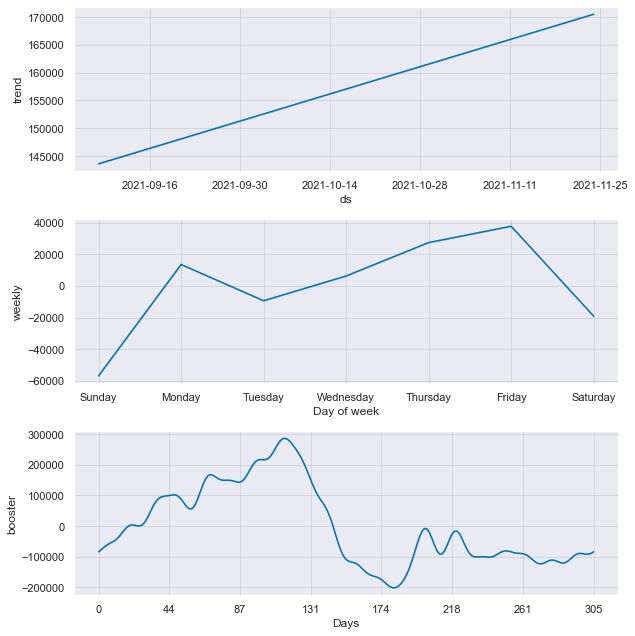

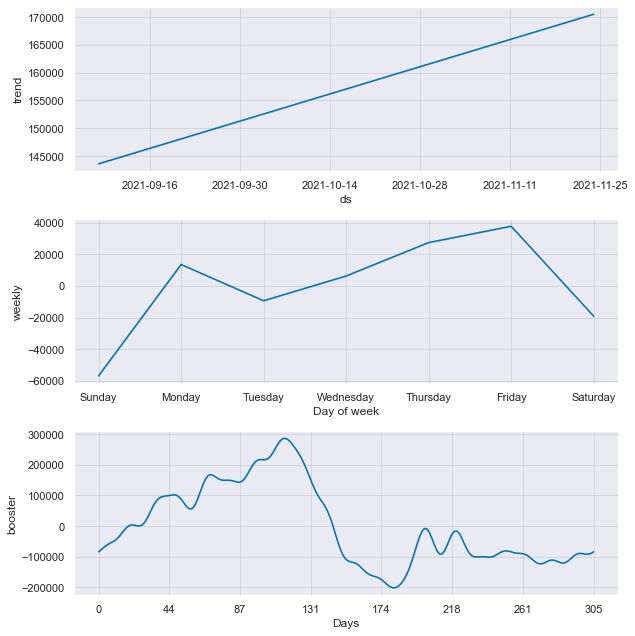

In [168]:
CA_model_in.plot_components(forecast_CA_in)

In [169]:
from sklearn.metrics import mean_absolute_error
y_true = Canada_prophet['y'][250:].values
y_pred = forecast_CA_in['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse)

r2 = r2_score(y_true, y_pred)
print('R2 score is {}'.format(r2))


MAE: 44485.898
MSE: 2553163075.197
R2 score is -1.685269146414607


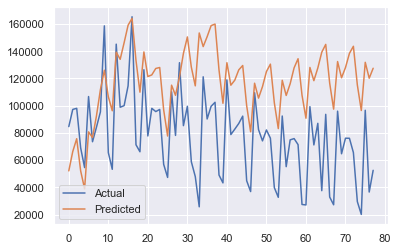

In [170]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

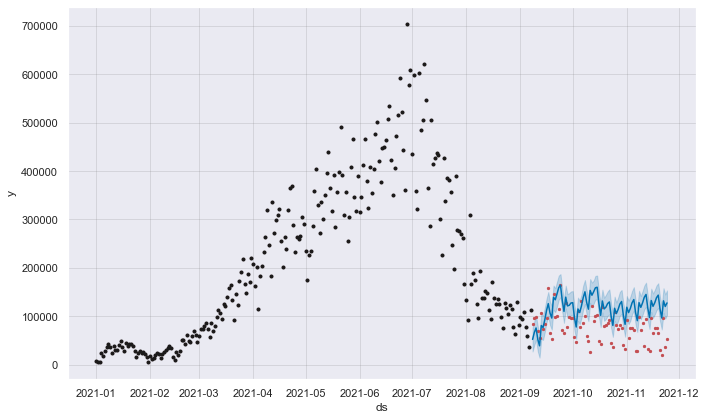

In [171]:
fig = CA_model_in.plot(forecast_CA_in)
plt.scatter(x=Canada_prophet[['ds']], y=Canada_prophet[['y']], color='r', s=5)

plt.show()

### Canada Out-Sample Model Forecast
#### Make Predictions for the next 365 days

In [82]:
CA_model_out = Prophet().add_seasonality(
                        name='booster',
                        period=11*30.5,
                        fourier_order=20)
CA_model_out.fit(Canada_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [83]:
future = CA_model_out.make_future_dataframe(periods=365)
future.tail()

,ds
688,2022-11-20
689,2022-11-21
690,2022-11-22
691,2022-11-23
692,2022-11-24


In [84]:
forecast_CA_out = CA_model_out.predict(future)
forecast_CA_out["yhat"] = np.where(forecast_CA_out["yhat"]<0,0,forecast_CA_out["yhat"])
forecast_CA_out["yhat_lower"] = np.where(forecast_CA_out["yhat_lower"]<0,0,forecast_CA_out["yhat_lower"])
forecast_CA_out["yhat_upper"] = np.where(forecast_CA_out["yhat_upper"]<0,0,forecast_CA_out["yhat_upper"])
forecast_CA_out[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
688,2022-11-20,181338.346143,137586.927430,225941.953053
689,2022-11-21,249075.734090,202626.275700,296160.958407
690,2022-11-22,224347.982140,176401.661905,268933.381939
691,2022-11-23,237012.200766,193463.217420,279776.005261
692,2022-11-24,250793.495401,208156.342660,294950.582638


In [85]:
#Taking predictions and dividing by ____, this is due to boosters only being 1 dose, 
#while incorporating the fact that some people will still get their 1st and 2nd dose giong forward
before = forecast_CA_out[forecast_CA_out['ds'] < '2021-11-30']
after = forecast_CA_out[forecast_CA_out['ds'] >= '2021-11-30']

d = (after.drop(columns='ds')/2)
d['ds'] = after[['ds']]
col = d.pop('ds')
d.insert(0, col.name, col)
frames = [before, d]
forecast_CA_out = pd.concat(frames)
forecast_CA_out.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,booster,booster_lower,booster_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
688,2022-11-20,165867.469229,68793.463715,112970.976527,165867.442920,165867.496568,-75198.296157,-75198.296157,-75198.296157,-49153.526335,-49153.526335,-49153.526335,-26044.769822,-26044.769822,-26044.769822,0.0,0.0,0.0,90669.173072
689,2022-11-21,166012.443546,101313.137850,148080.479204,166012.417071,166012.470948,-41474.576501,-41474.576501,-41474.576501,-49662.946003,-49662.946003,-49662.946003,8188.369502,8188.369502,8188.369502,0.0,0.0,0.0,124537.867045
690,2022-11-22,166157.417863,88200.830952,134466.690969,166157.391197,166157.445327,-53983.426793,-53983.426793,-53983.426793,-50371.192720,-50371.192720,-50371.192720,-3612.234073,-3612.234073,-3612.234073,0.0,0.0,0.0,112173.991070
691,2022-11-23,166302.392180,96731.608710,139888.002630,166302.365324,166302.419706,-47796.291797,-47796.291797,-47796.291797,-51277.850084,-51277.850084,-51277.850084,3481.558287,3481.558287,3481.558287,0.0,0.0,0.0,118506.100383
692,2022-11-24,166447.366498,104078.171330,147475.291319,166447.339450,166447.394162,-41050.618797,-41050.618797,-41050.618797,-52367.738030,-52367.738030,-52367.738030,11317.119233,11317.119233,11317.119233,0.0,0.0,0.0,125396.747701


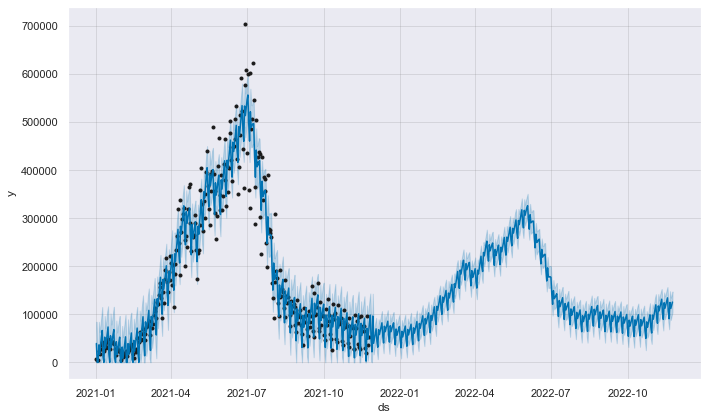

In [86]:
fig = CA_model_out.plot(forecast_CA_out)


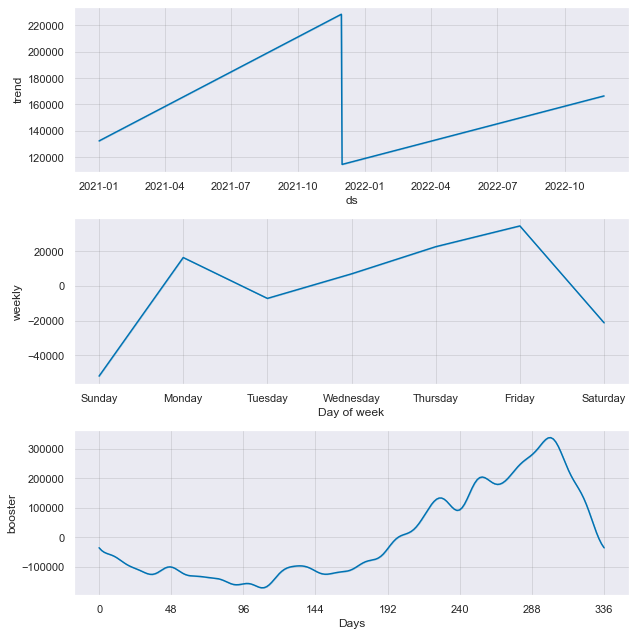

In [87]:
fig = CA_model_out.plot_components(forecast_CA_out)

### United States In-Sample Model Forecast
#### This allows us to see the accuracy of our model on previous data.

In [135]:
# train test split US data
train_US = US_prophet[:250]
test_US = US_prophet[250:]


In [136]:
# Fit Prophet model on the training data
US_model_in = Prophet().add_seasonality(
                        name='booster',
                        period=10*30.5,
                        fourier_order=20)
US_model_in.fit(train_US)
forecast_US_in = US_model_in.predict(test_US)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [137]:
#dividing model results by 2 to account for boosters
dates = forecast_US_in[['ds']]
d = forecast_US_in.drop(columns='ds')
d = d/2
d['ds'] = dates
col = d.pop('ds')
d.insert(0, col.name, col)
forecast_US_in = d

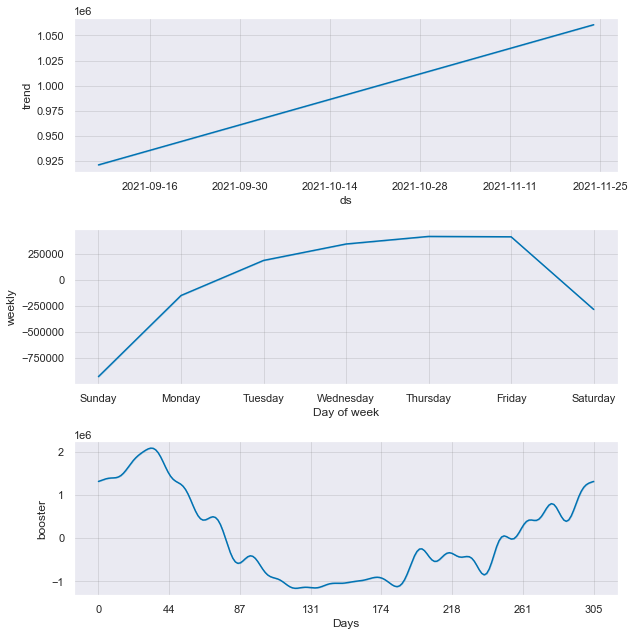

In [138]:
fig = US_model_in.plot_components(forecast_US_in)

In [139]:
y_true = US_prophet['y'][250:].values
y_pred = forecast_US_in['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

mse = mean_squared_error(y_true, y_pred)
print('MSE: %.3f' % mse)

r2 = r2_score(y_true, y_pred)
print('R2 score is {}'.format(r2))



MAE: 270458.646
MSE: 122383618852.391
R2 score is 0.2904962677640478


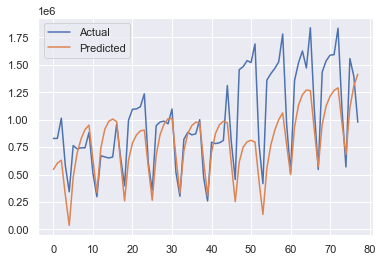

In [140]:
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

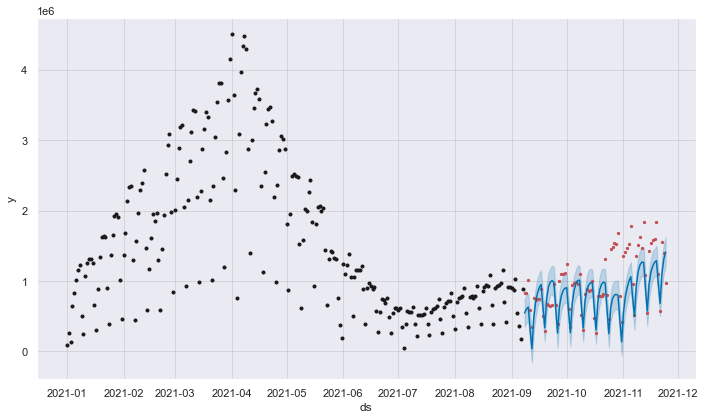

In [141]:
fig = US_model_in.plot(forecast_US_in)
plt.scatter(x=US_prophet[['ds']], y=US_prophet[['y']], color='r', s=5)

plt.show()

### United States Out-Sample Model Forecast
#### Make Predictions for the next 365 days

In [94]:
US_model_out = Prophet().add_seasonality(
                        name='booster',
                        period=10*30.5,
                        fourier_order=20)
US_model_out.fit(US_prophet)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [95]:
future = US_model_out.make_future_dataframe(periods=365)
future.tail()


,ds
688,2022-11-20
689,2022-11-21
690,2022-11-22
691,2022-11-23
692,2022-11-24


In [96]:
forecast_US_out = US_model_out.predict(future)
forecast_US_out["yhat"] = np.where(forecast_US_out["yhat"]<0,0,forecast_US_out["yhat"])
forecast_US_out["yhat_lower"] = np.where(forecast_US_out["yhat_lower"]<0,0,forecast_US_out["yhat_lower"])
forecast_US_out["yhat_upper"] = np.where(forecast_US_out["yhat_upper"]<0,0,forecast_US_out["yhat_upper"])
forecast_US_out[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
688,2022-11-20,2.613958e+06,2.231755e+06,3.019318e+06
689,2022-11-21,3.405816e+06,3.051399e+06,3.777038e+06
690,2022-11-22,3.710428e+06,3.330031e+06,4.097772e+06
691,2022-11-23,3.869841e+06,3.492604e+06,4.257197e+06
692,2022-11-24,3.997381e+06,3.596578e+06,4.402238e+06


In [97]:
#Taking predictions and dividing by ____, this is due to boosters only being 1 dose, 
#while incorporating the fact that some people will still get their 1st and 2nd dose giong forward
before = forecast_US_out[forecast_US_out['ds'] < '2021-11-30']
after = forecast_US_out[forecast_US_out['ds'] >= '2021-11-30']

d = (after.drop(columns='ds')/2)
d['ds'] = after[['ds']]
col = d.pop('ds')
d.insert(0, col.name, col)
frames = [before, d]
forecast_US_out = pd.concat(frames)
forecast_US_out.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,booster,booster_lower,booster_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
688,2022-11-20,1.044280e+06,1.115878e+06,1.509659e+06,1.042946e+06,1.045821e+06,262699.308776,262699.308776,262699.308776,688241.930712,688241.930712,688241.930712,-425542.621937,-425542.621937,-425542.621937,0.0,0.0,0.0,1.306979e+06
689,2022-11-21,1.044938e+06,1.525700e+06,1.888519e+06,1.043597e+06,1.046486e+06,657970.559832,657970.559832,657970.559832,702687.494665,702687.494665,702687.494665,-44716.934833,-44716.934833,-44716.934833,0.0,0.0,0.0,1.702908e+06
690,2022-11-22,1.045595e+06,1.665015e+06,2.048886e+06,1.044246e+06,1.047151e+06,809618.550588,809618.550588,809618.550588,721933.585069,721933.585069,721933.585069,87684.965519,87684.965519,87684.965519,0.0,0.0,0.0,1.855214e+06
691,2022-11-23,1.046253e+06,1.746302e+06,2.128599e+06,1.044896e+06,1.047815e+06,888667.374318,888667.374318,888667.374318,745607.578382,745607.578382,745607.578382,143059.795936,143059.795936,143059.795936,0.0,0.0,0.0,1.934920e+06
692,2022-11-24,1.046911e+06,1.798289e+06,2.201119e+06,1.045550e+06,1.048480e+06,951780.032367,951780.032367,951780.032367,772782.001068,772782.001068,772782.001068,178998.031299,178998.031299,178998.031299,0.0,0.0,0.0,1.998691e+06


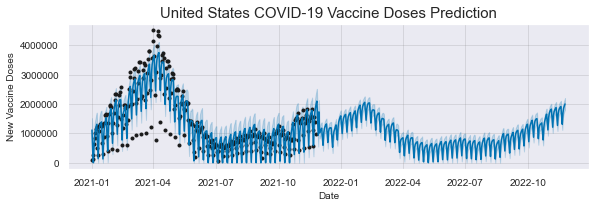

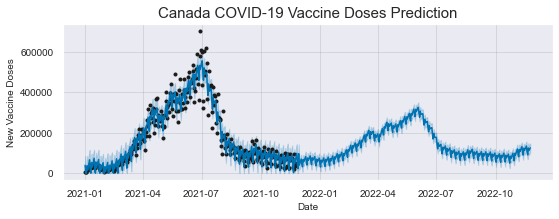

In [98]:
from prophet.plot import plot

fig = US_model_out.plot(forecast_US_out, xlabel='Date', ylabel='Vaccine Doses', figsize=(8, 3))
ax = fig.gca()
plt.ticklabel_format(style='plain', axis='y')
ax.set_title("United States COVID-19 Vaccine Doses Prediction", size=15)
ax.set_xlabel("Date", size=10)
ax.set_ylabel("New Vaccine Doses", size=10)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)

fig = CA_model_out.plot(forecast_CA_out, xlabel='Date', ylabel='Vaccine Doses', figsize=(8, 3))
ax = fig.gca()
ax.set_title("Canada COVID-19 Vaccine Doses Prediction", size=15)
ax.set_xlabel("Date", size=10)
ax.set_ylabel("New Vaccine Doses", size=10)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)


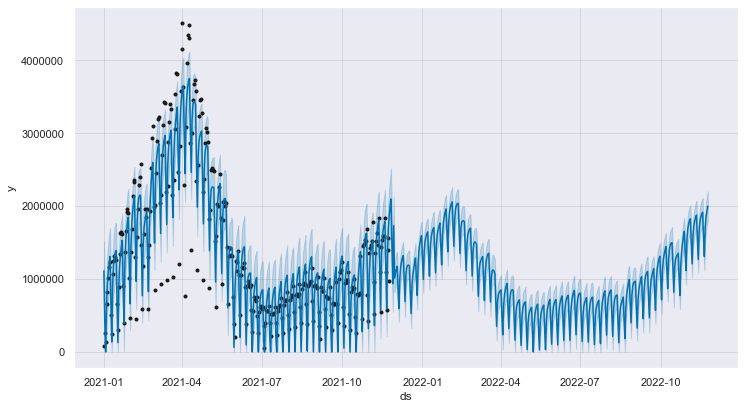

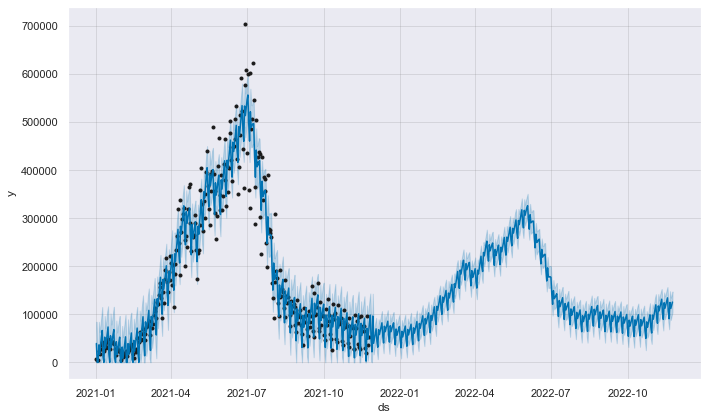

In [99]:


US_future_plot = US_model_out.plot(forecast_US_out)
plt.ticklabel_format(style='plain', axis='y')

fig = CA_model_out.plot(forecast_CA_out)
plt.ticklabel_format(style='plain', axis='y')


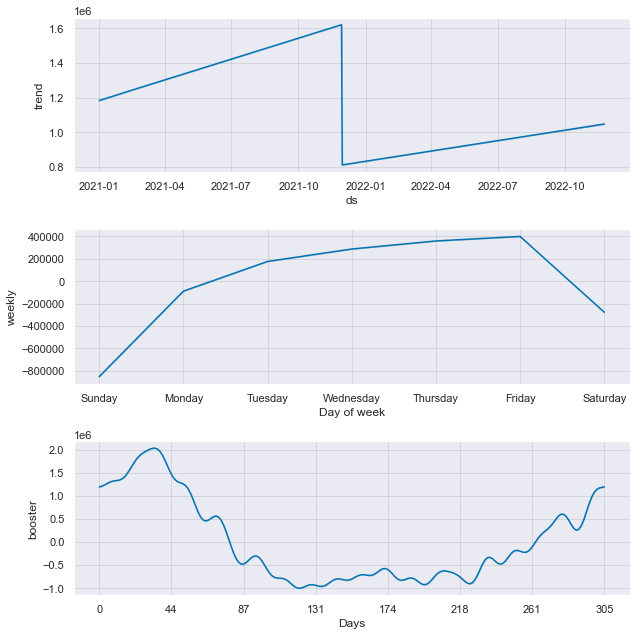

In [100]:
fig = US_model_out.plot_components(forecast_US_out)